In [1]:
import pandas as pd
import numpy as np
import os
import sys
import polars as pl
import json
from joblib import Parallel, delayed
import deepchem
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Configure Polars 
cfg = pl.Config()
cfg.set_tbl_rows(20)
cfg.set_tbl_cols(50)
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, GroupShuffleSplit, ShuffleSplit, StratifiedKFold
import gc
import random

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/opt/conda/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
PERCENTILES = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99]

## Load data

In [3]:
with open('/home/dangnh36/datasets/competitions/leash_belka/processed/meta/building_blocks.json', 'r') as f:
    bbs_meta = json.load(f)
    
for k, v in bbs_meta.items():
    print(k, '-->', len(v)) 

train_bbs --> 1145
train_bb1s --> 271
train_bb2s --> 693
train_bb3s --> 872
test_bb1s --> 341
test_bb2s --> 1140
test_bb3s --> 1389
test_bbs --> 2110
all_bbs --> 2110


#### Train data

In [4]:
train_scaffolds = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_scaffold.csv').collect()
train_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_v2.csv')\
    .select(
        pl.col('molecule'),
        pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        pl.col('BRD4', 'HSA', 'sEH').cast(pl.UInt8),
        scaffold_idx = train_scaffolds['scaffold_idx'],
    )\
    .collect()
print(train_df.shape, train_df.estimated_size('mb'))
train_df

(98415610, 8) 8601.91998577118


shape: (98_415_610, 8)
┌───────────────────────────────────┬──────┬──────┬──────┬──────┬─────┬─────┬──────────────┐
│ molecule                          ┆ bb1  ┆ bb2  ┆ bb3  ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_idx │
│ ---                               ┆ ---  ┆ ---  ┆ ---  ┆ ---  ┆ --- ┆ --- ┆ ---          │
│ str                               ┆ u16  ┆ u16  ┆ u16  ┆ u8   ┆ u8  ┆ u8  ┆ i64          │
╞═══════════════════════════════════╪══════╪══════╪══════╪══════╪═════╪═════╪══════════════╡
│ C#CCOc1ccc(CNc2nc(NCC3CCCN3c3ccc… ┆ 1640 ┆ 1653 ┆ 765  ┆ 0    ┆ 0   ┆ 0   ┆ 4283326      │
│ C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3… ┆ 1640 ┆ 1653 ┆ 205  ┆ 0    ┆ 0   ┆ 0   ┆ 4486646      │
│ C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)… ┆ 1640 ┆ 1653 ┆ 1653 ┆ 0    ┆ 0   ┆ 0   ┆ 1015728      │
│ C#CCOc1ccc(CNc2nc(NCCNC(=O)C(=C)… ┆ 1640 ┆ 1653 ┆ 146  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385      │
│ C#CCOc1ccc(CNc2nc(NCC(=O)NCC=C)n… ┆ 1640 ┆ 1653 ┆ 439  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385      │
│ C#CCOc1ccc(CNc2nc(NCC(C)OCC=C)nc… ┆ 1640 ┆ 1653 ┆ 196  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385      │
│ C#CCOc1ccc(CNc2nc(NCCCOCC=C)nc(N… ┆ 1640 ┆ 1653 ┆ 253  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385      │
│ C#CCOc1ccc(CNc2nc(NCCOCC=C)nc(N[… ┆ 1640 ┆ 1653 ┆ 1219 ┆ 0    ┆ 0   ┆ 0   ┆ 5301385      │
│ C#CCOc1ccc(CNc2nc(Nc3cnn(C4CCN(C… ┆ 1640 ┆ 1653 ┆ 604  ┆ 0    ┆ 0   ┆ 0   ┆ 543172       │
│ C#CCOc1ccc(CNc2nc(Nc3n[nH]c4c3CN… ┆ 1640 ┆ 1653 ┆ 121  ┆ 0    ┆ 0   ┆ 0   ┆ 2571428      │
│ …                                 ┆ …    ┆ …    ┆ …    ┆ …    ┆ …   ┆ …   ┆ …            │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2ncc… ┆ 141  ┆ 1415 ┆ 536  ┆ 0    ┆ 0   ┆ 0   ┆ 4068980      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2ncn… ┆ 141  ┆ 1415 ┆ 1367 ┆ 0    ┆ 0   ┆ 0   ┆ 2088996      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2ncn… ┆ 141  ┆ 1415 ┆ 329  ┆ 0    ┆ 0   ┆ 0   ┆ 3192765      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2noc… ┆ 141  ┆ 1415 ┆ 757  ┆ 0    ┆ 0   ┆ 0   ┆ 4085046      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2ncn… ┆ 141  ┆ 1415 ┆ 335  ┆ 0    ┆ 0   ┆ 0   ┆ 4087757      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2noc… ┆ 141  ┆ 1415 ┆ 1792 ┆ 0    ┆ 0   ┆ 0   ┆ 4674025      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2nnc… ┆ 141  ┆ 1415 ┆ 1178 ┆ 0    ┆ 0   ┆ 0   ┆ 5240137      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2nnc… ┆ 141  ┆ 1415 ┆ 1699 ┆ 0    ┆ 0   ┆ 0   ┆ 5240137      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2nnn… ┆ 141  ┆ 1415 ┆ 1308 ┆ 0    ┆ 0   ┆ 0   ┆ 3617024      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2noc… ┆ 141  ┆ 1415 ┆ 1415 ┆ 0    ┆ 0   ┆ 0   ┆ 268351       │
└───────────────────────────────────┴──────┴──────┴──────┴──────┴─────┴─────┴──────────────┘

#### Test data

In [5]:
test_scaffolds = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_scaffold.csv').collect()
test_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_v2.csv')\
    .select(
        pl.col('id','molecule'),
        pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        pl.col('protein'),
        scaffold_idx = test_scaffolds['scaffold_idx']
    ).group_by('molecule').first().sort('id').collect()
print(test_df.shape, test_df.estimated_size('mb'))
test_df

(878022, 7) 84.21934127807617


shape: (878_022, 7)
┌───────────────────────────────────┬───────────┬──────┬──────┬──────┬─────────┬──────────────┐
│ molecule                          ┆ id        ┆ bb1  ┆ bb2  ┆ bb3  ┆ protein ┆ scaffold_idx │
│ ---                               ┆ ---       ┆ ---  ┆ ---  ┆ ---  ┆ ---     ┆ ---          │
│ str                               ┆ i64       ┆ u16  ┆ u16  ┆ u16  ┆ str     ┆ i64          │
╞═══════════════════════════════════╪═══════════╪══════╪══════╪══════╪═════════╪══════════════╡
│ C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2… ┆ 295246830 ┆ 1989 ┆ 409  ┆ 409  ┆ BRD4    ┆ 2217250      │
│ C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2… ┆ 295246833 ┆ 1989 ┆ 409  ┆ 1012 ┆ BRD4    ┆ 602641       │
│ C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C… ┆ 295246836 ┆ 1989 ┆ 409  ┆ 1722 ┆ BRD4    ┆ 4502748      │
│ C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2… ┆ 295246839 ┆ 1989 ┆ 409  ┆ 1078 ┆ BRD4    ┆ 3936208      │
│ C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2… ┆ 295246842 ┆ 1989 ┆ 409  ┆ 605  ┆ BRD4    ┆ 4550856      │
│ C#CCCC[C@H](Nc1nc(NCc2ccc(C)cc2N… ┆ 295246845 ┆ 1989 ┆ 409  ┆ 521  ┆ BRD4    ┆ 4414349      │
│ C#CCCC[C@H](Nc1nc(NCCc2ccc(OCC(=… ┆ 295246848 ┆ 1989 ┆ 409  ┆ 41   ┆ BRD4    ┆ 5367715      │
│ C#CCCC[C@H](Nc1nc(NCCCNC(=O)c2oc… ┆ 295246851 ┆ 1989 ┆ 409  ┆ 1826 ┆ BRD4    ┆ 1422452      │
│ C#CCCC[C@H](Nc1nc(NCc2nnc(N3CCCC… ┆ 295246854 ┆ 1989 ┆ 409  ┆ 1970 ┆ BRD4    ┆ 4752663      │
│ C#CCCC[C@H](Nc1nc(NCCc2csc3ccccc… ┆ 295246857 ┆ 1989 ┆ 409  ┆ 598  ┆ BRD4    ┆ 5758930      │
│ …                                 ┆ …         ┆ …    ┆ …    ┆ …    ┆ …       ┆ …            │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2nc(… ┆ 296921696 ┆ 141  ┆ 1474 ┆ 712  ┆ BRD4    ┆ 1758733      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2ncn… ┆ 296921699 ┆ 141  ┆ 1792 ┆ 227  ┆ BRD4    ┆ 3258407      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2cn3… ┆ 296921702 ┆ 141  ┆ 1792 ┆ 1092 ┆ BRD4    ┆ 3526087      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(NCC2(c… ┆ 296921705 ┆ 141  ┆ 120  ┆ 1280 ┆ BRD4    ┆ 4100278      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(NCC2CC… ┆ 296921708 ┆ 141  ┆ 1178 ┆ 1254 ┆ BRD4    ┆ 2925996      │
│ Cn1ncc2cc(Nc3nc(Nc4nncs4)nc(N[C@… ┆ 296921711 ┆ 141  ┆ 1699 ┆ 307  ┆ BRD4    ┆ 3694466      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(NCC2CC… ┆ 296921714 ┆ 141  ┆ 1699 ┆ 1254 ┆ BRD4    ┆ 2925996      │
│ COC(=O)c1ccnc(Nc2nc(Nc3noc4ccc(F… ┆ 296921717 ┆ 141  ┆ 1415 ┆ 1390 ┆ BRD4    ┆ 926159       │
│ COC1CCC(CCNc2nc(Nc3noc4ccc(F)cc3… ┆ 296921720 ┆ 141  ┆ 1415 ┆ 1556 ┆ BRD4    ┆ 3642883      │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(NCc2cc… ┆ 296921723 ┆ 141  ┆ 1415 ┆ 236  ┆ BRD4    ┆ 2851961      │
└───────────────────────────────────┴───────────┴──────┴──────┴──────┴─────────┴──────────────┘

In [6]:
df = pl.concat([train_df.select(pl.col('molecule', 'bb1', 'bb2', 'bb3', 'scaffold_idx'), ori=pl.lit(0)),
                test_df.select(pl.col('molecule', 'bb1', 'bb2', 'bb3', 'scaffold_idx'), ori= pl.lit(1))])
df = df.with_columns(
    pl.col('molecule').count().over('scaffold_idx').alias('mol_per_scaf')
)

df

shape: (99_293_632, 7)
┌───────────────────────────────────┬──────┬──────┬──────┬──────────────┬─────┬──────────────┐
│ molecule                          ┆ bb1  ┆ bb2  ┆ bb3  ┆ scaffold_idx ┆ ori ┆ mol_per_scaf │
│ ---                               ┆ ---  ┆ ---  ┆ ---  ┆ ---          ┆ --- ┆ ---          │
│ str                               ┆ u16  ┆ u16  ┆ u16  ┆ i64          ┆ i32 ┆ u32          │
╞═══════════════════════════════════╪══════╪══════╪══════╪══════════════╪═════╪══════════════╡
│ C#CCOc1ccc(CNc2nc(NCC3CCCN3c3ccc… ┆ 1640 ┆ 1653 ┆ 765  ┆ 4283326      ┆ 0   ┆ 844          │
│ C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3… ┆ 1640 ┆ 1653 ┆ 205  ┆ 4486646      ┆ 0   ┆ 9444         │
│ C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)… ┆ 1640 ┆ 1653 ┆ 1653 ┆ 1015728      ┆ 0   ┆ 9030         │
│ C#CCOc1ccc(CNc2nc(NCCNC(=O)C(=C)… ┆ 1640 ┆ 1653 ┆ 146  ┆ 5301385      ┆ 0   ┆ 26814        │
│ C#CCOc1ccc(CNc2nc(NCC(=O)NCC=C)n… ┆ 1640 ┆ 1653 ┆ 439  ┆ 5301385      ┆ 0   ┆ 26814        │
│ C#CCOc1ccc(CNc2nc(NCC(C)OCC=C)nc… ┆ 1640 ┆ 1653 ┆ 196  ┆ 5301385      ┆ 0   ┆ 26814        │
│ C#CCOc1ccc(CNc2nc(NCCCOCC=C)nc(N… ┆ 1640 ┆ 1653 ┆ 253  ┆ 5301385      ┆ 0   ┆ 26814        │
│ C#CCOc1ccc(CNc2nc(NCCOCC=C)nc(N[… ┆ 1640 ┆ 1653 ┆ 1219 ┆ 5301385      ┆ 0   ┆ 26814        │
│ C#CCOc1ccc(CNc2nc(Nc3cnn(C4CCN(C… ┆ 1640 ┆ 1653 ┆ 604  ┆ 543172       ┆ 0   ┆ 844          │
│ C#CCOc1ccc(CNc2nc(Nc3n[nH]c4c3CN… ┆ 1640 ┆ 1653 ┆ 121  ┆ 2571428      ┆ 0   ┆ 864          │
│ …                                 ┆ …    ┆ …    ┆ …    ┆ …            ┆ …   ┆ …            │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2nc(… ┆ 141  ┆ 1474 ┆ 712  ┆ 1758733      ┆ 1   ┆ 20           │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2ncn… ┆ 141  ┆ 1792 ┆ 227  ┆ 3258407      ┆ 1   ┆ 20           │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(Nc2cn3… ┆ 141  ┆ 1792 ┆ 1092 ┆ 3526087      ┆ 1   ┆ 20           │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(NCC2(c… ┆ 141  ┆ 120  ┆ 1280 ┆ 4100278      ┆ 1   ┆ 260          │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(NCC2CC… ┆ 141  ┆ 1178 ┆ 1254 ┆ 2925996      ┆ 1   ┆ 60           │
│ Cn1ncc2cc(Nc3nc(Nc4nncs4)nc(N[C@… ┆ 141  ┆ 1699 ┆ 307  ┆ 3694466      ┆ 1   ┆ 180          │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(NCC2CC… ┆ 141  ┆ 1699 ┆ 1254 ┆ 2925996      ┆ 1   ┆ 60           │
│ COC(=O)c1ccnc(Nc2nc(Nc3noc4ccc(F… ┆ 141  ┆ 1415 ┆ 1390 ┆ 926159       ┆ 1   ┆ 904          │
│ COC1CCC(CCNc2nc(Nc3noc4ccc(F)cc3… ┆ 141  ┆ 1415 ┆ 1556 ┆ 3642883      ┆ 1   ┆ 116          │
│ [N-]=[N+]=NCCC[C@H](Nc1nc(NCc2cc… ┆ 141  ┆ 1415 ┆ 236  ┆ 2851961      ┆ 1   ┆ 88           │
└───────────────────────────────────┴──────┴──────┴──────┴──────────────┴─────┴──────────────┘

In [7]:
(df.filter(pl.col('ori') == 0)['molecule'] == train_df['molecule']).all()

True

In [8]:
train_df = train_df.with_columns((pl.col('BRD4') * 4 + pl.col('HSA') * 2 + pl.col('sEH')).alias('label'),
                                 mol_per_scaf = df.filter(pl.col('ori') == 0)['mol_per_scaf'])
train_df

shape: (98_415_610, 10)
┌────────────────────┬──────┬──────┬──────┬──────┬─────┬─────┬──────────────┬───────┬──────────────┐
│ molecule           ┆ bb1  ┆ bb2  ┆ bb3  ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_idx ┆ label ┆ mol_per_scaf │
│ ---                ┆ ---  ┆ ---  ┆ ---  ┆ ---  ┆ --- ┆ --- ┆ ---          ┆ ---   ┆ ---          │
│ str                ┆ u16  ┆ u16  ┆ u16  ┆ u8   ┆ u8  ┆ u8  ┆ i64          ┆ u8    ┆ u32          │
╞════════════════════╪══════╪══════╪══════╪══════╪═════╪═════╪══════════════╪═══════╪══════════════╡
│ C#CCOc1ccc(CNc2nc( ┆ 1640 ┆ 1653 ┆ 765  ┆ 0    ┆ 0   ┆ 0   ┆ 4283326      ┆ 0     ┆ 844          │
│ NCC3CCCN3c3ccc…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ C#CCOc1ccc(CNc2nc( ┆ 1640 ┆ 1653 ┆ 205  ┆ 0    ┆ 0   ┆ 0   ┆ 4486646      ┆ 0     ┆ 9444         │
│ NCc3cccc(Br)n3…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ C#CCOc1ccc(CNc2nc( ┆ 1640 ┆ 1653 ┆ 1653 ┆ 0    ┆ 0   ┆ 0   ┆ 1015728      ┆ 0     ┆ 9030         │
│ NCc3ccc(OCC#C)…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ C#CCOc1ccc(CNc2nc( ┆ 1640 ┆ 1653 ┆ 146  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385      ┆ 0     ┆ 26814        │
│ NCCNC(=O)C(=C)…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ C#CCOc1ccc(CNc2nc( ┆ 1640 ┆ 1653 ┆ 439  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385      ┆ 0     ┆ 26814        │
│ NCC(=O)NCC=C)n…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ C#CCOc1ccc(CNc2nc( ┆ 1640 ┆ 1653 ┆ 196  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385      ┆ 0     ┆ 26814        │
│ NCC(C)OCC=C)nc…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ C#CCOc1ccc(CNc2nc( ┆ 1640 ┆ 1653 ┆ 253  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385      ┆ 0     ┆ 26814        │
│ NCCCOCC=C)nc(N…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ C#CCOc1ccc(CNc2nc( ┆ 1640 ┆ 1653 ┆ 1219 ┆ 0    ┆ 0   ┆ 0   ┆ 5301385      ┆ 0     ┆ 26814        │
│ NCCOCC=C)nc(N[…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ C#CCOc1ccc(CNc2nc( ┆ 1640 ┆ 1653 ┆ 604  ┆ 0    ┆ 0   ┆ 0   ┆ 543172       ┆ 0     ┆ 844          │
│ Nc3cnn(C4CCN(C…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ C#CCOc1ccc(CNc2nc( ┆ 1640 ┆ 1653 ┆ 121  ┆ 0    ┆ 0   ┆ 0   ┆ 2571428      ┆ 0     ┆ 864          │
│ Nc3n[nH]c4c3CN…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ …                  ┆ …    ┆ …    ┆ …    ┆ …    ┆ …   ┆ …   ┆ …            ┆ …     ┆ …            │
│ [N-]=[N+]=NCCC[C@H ┆ 141  ┆ 1415 ┆ 536  ┆ 0    ┆ 0   ┆ 0   ┆ 4068980      ┆ 0     ┆ 276          │
│ ](Nc1nc(Nc2ncc…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ [N-]=[N+]=NCCC[C@H ┆ 141  ┆ 1415 ┆ 1367 ┆ 0    ┆ 0   ┆ 0   ┆ 2088996      ┆ 0     ┆ 20           │
│ ](Nc1nc(Nc2ncn…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ [N-]=[N+]=NCCC[C@H ┆ 141  ┆ 1415 ┆ 329  ┆ 0    ┆ 0   ┆ 0   ┆ 3192765      ┆ 0     ┆ 260          │
│ ](Nc1nc(Nc2ncn…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ [N-]=[N+]=NCCC[C@H ┆ 141  ┆ 1415 ┆ 757  ┆ 0    ┆ 0   ┆ 0   ┆ 4085046      ┆ 0     ┆ 20           │
│ ](Nc1nc(Nc2noc…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ [N-]=[N+]=NCCC[C@H ┆ 141  ┆ 1415 ┆ 335  ┆ 0    ┆ 0   ┆ 0   ┆ 4087757      ┆ 0     ┆ 20           │
│ ](Nc1nc(Nc2ncn…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ [N-]=[N+]=NCCC[C@H ┆ 141  ┆ 1415 ┆ 1792 ┆ 0    ┆ 0   ┆ 0   ┆ 4674025      ┆ 0     ┆ 20           │
│ ](Nc1nc(Nc2noc…    ┆      ┆      ┆      ┆      ┆     ┆     ┆              ┆       ┆              │
│ [N-]=[N+]=NCCC[C@H ┆ 141  ┆ 1415 ┆ 1178 ┆ 0    ┆ 0   ┆ 0   ┆ 5240137      ┆ 0     ┆ 60           │
│ ](Nc1nc(Nc2nnc…    ┆      ┆      ┆ 

In [9]:
train_df.select(pl.n_unique('*'))

shape: (1, 10)
┌──────────┬─────┬─────┬─────┬──────┬─────┬─────┬──────────────┬───────┬──────────────┐
│ molecule ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_idx ┆ label ┆ mol_per_scaf │
│ ---      ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ ---          ┆ ---   ┆ ---          │
│ u32      ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ u32          ┆ u32   ┆ u32          │
╞══════════╪═════╪═════╪═════╪══════╪═════╪═════╪══════════════╪═══════╪══════════════╡
│ 98415610 ┆ 271 ┆ 693 ┆ 872 ┆ 2    ┆ 2   ┆ 2   ┆ 5711873      ┆ 8     ┆ 2388         │
└──────────┴─────┴─────┴─────┴──────┴─────┴─────┴──────────────┴───────┴──────────────┘

In [10]:
del df, test_df, train_scaffolds, test_scaffolds
gc.collect()

11

## Determine non-share BBs

Ref: https://www.kaggle.com/competitions/leash-BELKA/discussion/496576

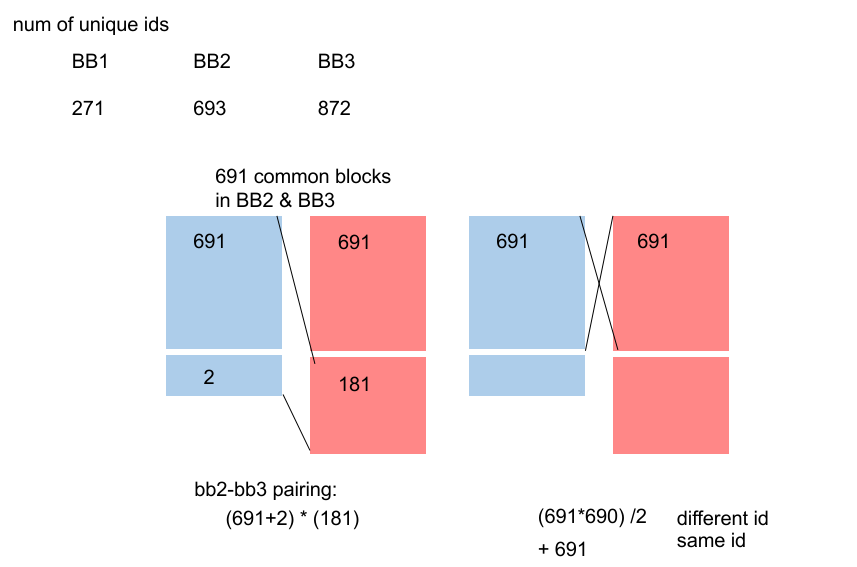
![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F113660%2F37d94487c09461f130fb48af3fa4ee2f%2FSelection_059.png?generation=1714355321671144&alt=media)

In [11]:
train_bb1s = set(bbs_meta['train_bb1s'])
train_bb2s = set(bbs_meta['train_bb2s'])
train_bb3s = set(bbs_meta['train_bb3s'])
all_bbs = bbs_meta['all_bbs']
len(train_bb1s), len(train_bb2s), len(train_bb3s), len(all_bbs)

(271, 693, 872, 2110)

In [12]:
len(set(train_bb2s.union(train_bb3s)))

874

In [13]:
bb23_181s = list(set(train_bb3s.difference(train_bb2s)))
bb23_691s = list(set(train_bb3s).difference(bb23_181s))
bb23_2s = list(set(train_bb2s).difference(bb23_691s))
len(bb23_181s), len(bb23_691s), len(bb23_2s)

(181, 691, 2)

In [14]:
set(bbs_meta['train_bb3s']).difference(set(bbs_meta['test_bb3s']))

{'CC1(CCCCN)OCCO1'}

In [15]:
'CC1(CCCCN)OCCO1' in bb23_691s

True

### BB1 split

we simulate non-shared (triazine part) of test set, with 2x17 bb1

In [14]:
271 / 17

15.941176470588236

In [16]:
# 271 / 17 ~ 16
splitter = StratifiedGroupKFold(n_splits=16, shuffle=True, random_state=42)

bb1_fold_meta = {}
for i, (train_idxs, val_idxs) in enumerate(splitter.split(list(range(len(train_df))), train_df['label'], train_df['bb1'])):
    bb1_fold_meta[i] = {}
    bb1_fold_meta[i]['train'] = train_df[train_idxs, 'bb1'].unique().to_list()
    bb1_fold_meta[i]['val'] = train_df[val_idxs, 'bb1'].unique().to_list()
    assert len(bb1_fold_meta[i]['train'] + bb1_fold_meta[i]['val']) == 271
    assert len(set(bb1_fold_meta[i]['val']).intersection(set(bb1_fold_meta[i]['train']))) == 0
    print(f"Fold {i}: {len(bb1_fold_meta[i]['train'])} + {len(bb1_fold_meta[i]['val'])}")

Fold 0: 254 + 17
Fold 1: 254 + 17
Fold 2: 254 + 17
Fold 3: 254 + 17
Fold 4: 254 + 17
Fold 5: 254 + 17
Fold 6: 254 + 17
Fold 7: 254 + 17
Fold 8: 254 + 17
Fold 9: 254 + 17
Fold 10: 254 + 17
Fold 11: 254 + 17
Fold 12: 254 + 17
Fold 13: 254 + 17
Fold 14: 255 + 16
Fold 15: 254 + 17


0 (6173388, 10)
shape: (1, 3)
┌──────────┬──────────┬──────────┐
│ BRD4     ┆ HSA      ┆ sEH      │
│ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╡
│ 0.822093 ┆ 0.495611 ┆ 0.342794 │
└──────────┴──────────┴──────────┘


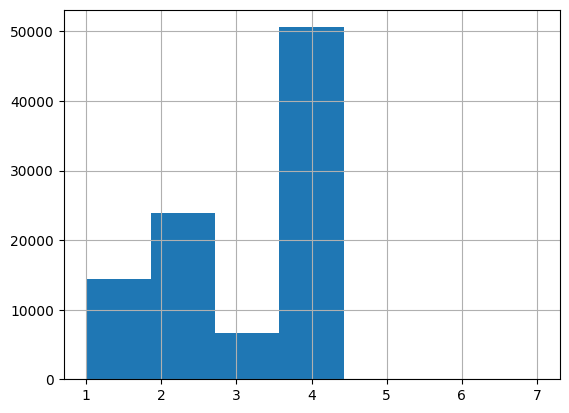

1 (6173084, 10)
shape: (1, 3)
┌──────────┬─────────┬──────────┐
│ BRD4     ┆ HSA     ┆ sEH      │
│ ---      ┆ ---     ┆ ---      │
│ f64      ┆ f64     ┆ f64      │
╞══════════╪═════════╪══════════╡
│ 0.291183 ┆ 0.38812 ┆ 4.509221 │
└──────────┴─────────┴──────────┘


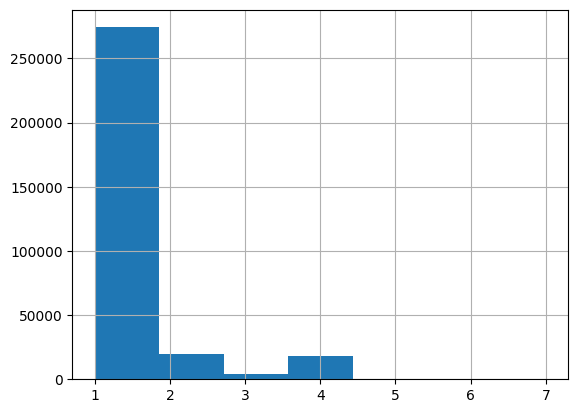

2 (6172887, 10)
shape: (1, 3)
┌───────┬──────────┬──────────┐
│ BRD4  ┆ HSA      ┆ sEH      │
│ ---   ┆ ---      ┆ ---      │
│ f64   ┆ f64      ┆ f64      │
╞═══════╪══════════╪══════════╡
│ 0.579 ┆ 0.356446 ┆ 0.314634 │
└───────┴──────────┴──────────┘


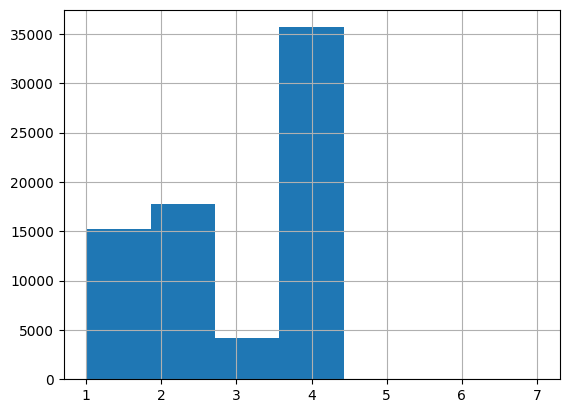

3 (6173832, 10)
shape: (1, 3)
┌──────────┬──────────┬──────────┐
│ BRD4     ┆ HSA      ┆ sEH      │
│ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╡
│ 0.586087 ┆ 0.408984 ┆ 0.343774 │
└──────────┴──────────┴──────────┘


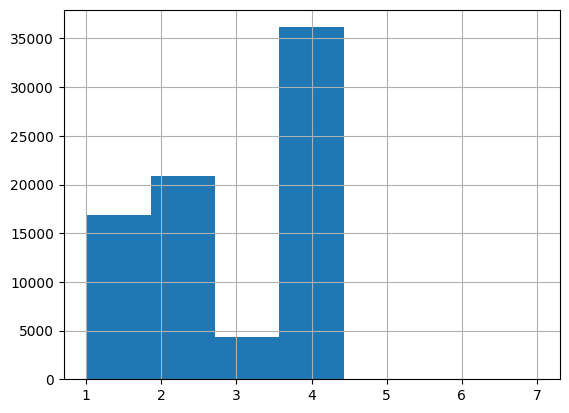

4 (6175214, 10)
shape: (1, 3)
┌──────────┬──────────┬──────────┐
│ BRD4     ┆ HSA      ┆ sEH      │
│ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╡
│ 0.541115 ┆ 0.419694 ┆ 0.365672 │
└──────────┴──────────┴──────────┘


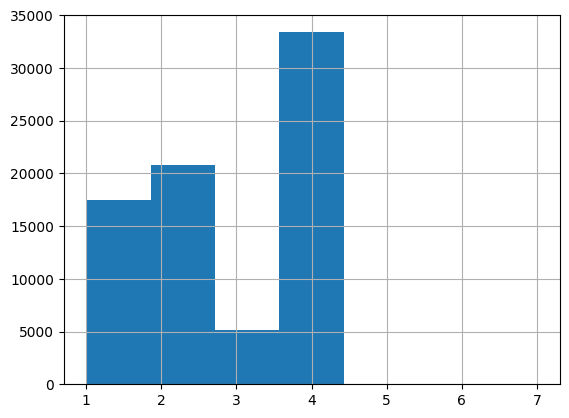

5 (6173395, 10)
shape: (1, 3)
┌──────────┬──────────┬──────────┐
│ BRD4     ┆ HSA      ┆ sEH      │
│ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╡
│ 0.287411 ┆ 0.342583 ┆ 0.194059 │
└──────────┴──────────┴──────────┘


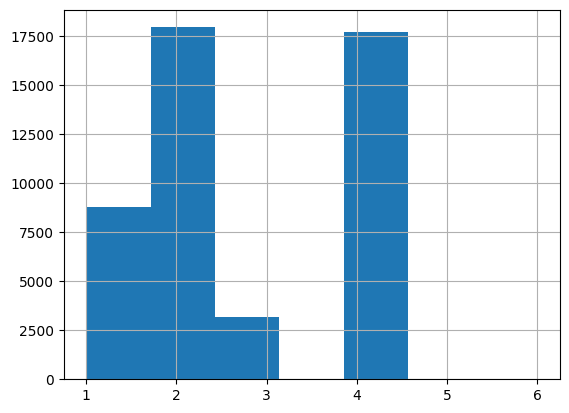

6 (6174733, 10)
shape: (1, 3)
┌─────────┬──────────┬──────────┐
│ BRD4    ┆ HSA      ┆ sEH      │
│ ---     ┆ ---      ┆ ---      │
│ f64     ┆ f64      ┆ f64      │
╞═════════╪══════════╪══════════╡
│ 0.20958 ┆ 0.461413 ┆ 0.274311 │
└─────────┴──────────┴──────────┘


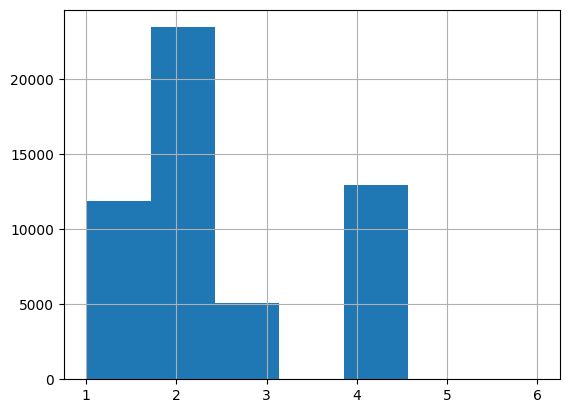

7 (6172790, 10)
shape: (1, 3)
┌──────────┬─────────┬──────────┐
│ BRD4     ┆ HSA     ┆ sEH      │
│ ---      ┆ ---     ┆ ---      │
│ f64      ┆ f64     ┆ f64      │
╞══════════╪═════════╪══════════╡
│ 0.315044 ┆ 0.30406 ┆ 0.215834 │
└──────────┴─────────┴──────────┘


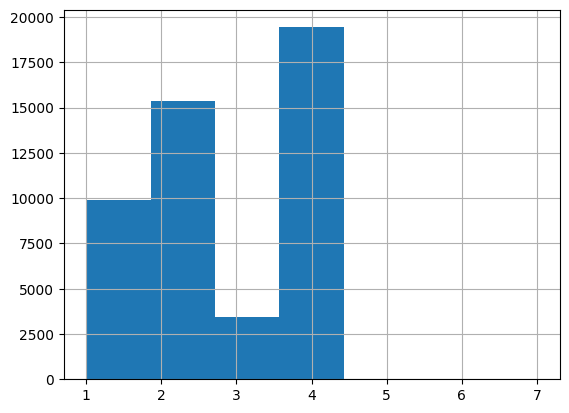

8 (6172498, 10)
shape: (1, 3)
┌─────────┬──────────┬──────────┐
│ BRD4    ┆ HSA      ┆ sEH      │
│ ---     ┆ ---      ┆ ---      │
│ f64     ┆ f64      ┆ f64      │
╞═════════╪══════════╪══════════╡
│ 0.23177 ┆ 0.293317 ┆ 0.209397 │
└─────────┴──────────┴──────────┘


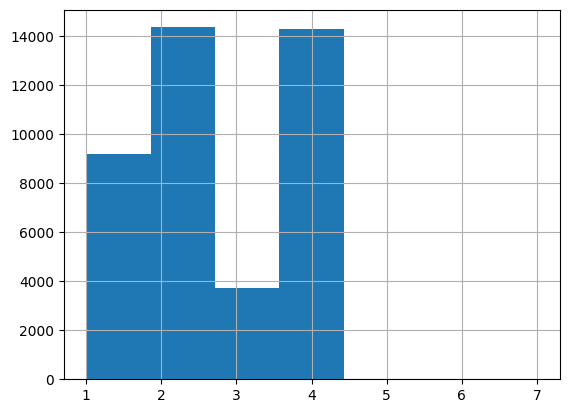

9 (6172903, 10)
shape: (1, 3)
┌──────────┬──────────┬──────────┐
│ BRD4     ┆ HSA      ┆ sEH      │
│ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╡
│ 0.647669 ┆ 0.473683 ┆ 0.297089 │
└──────────┴──────────┴──────────┘


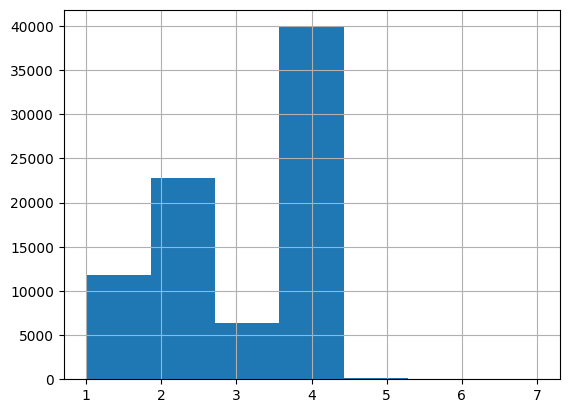

10 (6172308, 10)
shape: (1, 3)
┌─────────┬──────────┬──────────┐
│ BRD4    ┆ HSA      ┆ sEH      │
│ ---     ┆ ---      ┆ ---      │
│ f64     ┆ f64      ┆ f64      │
╞═════════╪══════════╪══════════╡
│ 0.55425 ┆ 0.390794 ┆ 0.316365 │
└─────────┴──────────┴──────────┘


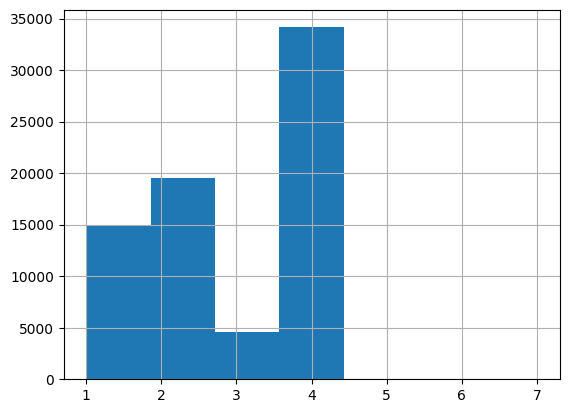

11 (6173817, 10)
shape: (1, 3)
┌──────────┬──────────┬──────────┐
│ BRD4     ┆ HSA      ┆ sEH      │
│ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╡
│ 0.472398 ┆ 0.355015 ┆ 0.342527 │
└──────────┴──────────┴──────────┘


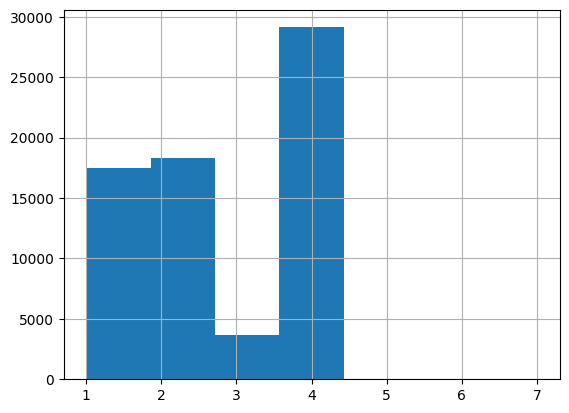

12 (6175514, 10)
shape: (1, 3)
┌──────────┬──────────┬──────────┐
│ BRD4     ┆ HSA      ┆ sEH      │
│ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╡
│ 0.220808 ┆ 0.409261 ┆ 0.226313 │
└──────────┴──────────┴──────────┘


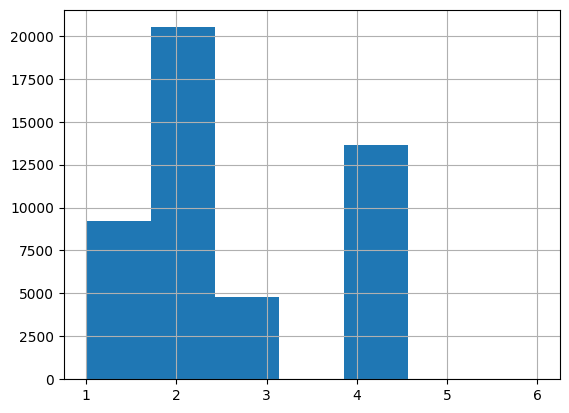

13 (6174149, 10)
shape: (1, 3)
┌─────────┬──────────┬──────────┐
│ BRD4    ┆ HSA      ┆ sEH      │
│ ---     ┆ ---      ┆ ---      │
│ f64     ┆ f64      ┆ f64      │
╞═════════╪══════════╪══════════╡
│ 0.74501 ┆ 0.454783 ┆ 0.351093 │
└─────────┴──────────┴──────────┘


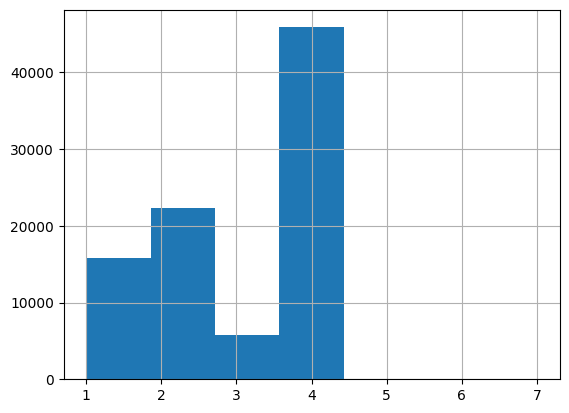

14 (5811177, 10)
shape: (1, 3)
┌──────────┬──────────┬─────────┐
│ BRD4     ┆ HSA      ┆ sEH     │
│ ---      ┆ ---      ┆ ---     │
│ f64      ┆ f64      ┆ f64     │
╞══════════╪══════════╪═════════╡
│ 0.634949 ┆ 0.577215 ┆ 0.38216 │
└──────────┴──────────┴─────────┘


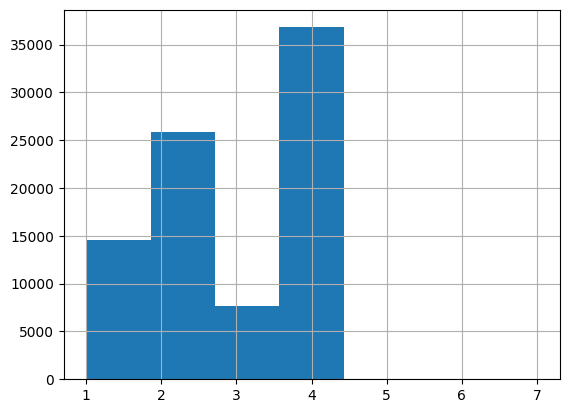

15 (6173921, 10)
shape: (1, 3)
┌──────────┬──────────┬──────────┐
│ BRD4     ┆ HSA      ┆ sEH      │
│ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╡
│ 0.300846 ┆ 0.518244 ┆ 3.073331 │
└──────────┴──────────┴──────────┘


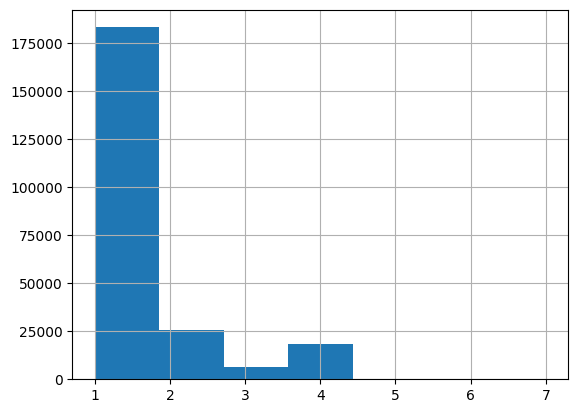

In [19]:
for fold_idx, fold_bb1s in bb1_fold_meta.items():
    val_df = train_df.filter(pl.col('bb1').is_in(fold_bb1s['val']))
    print(fold_idx, val_df.shape)
    print(val_df.select(pl.col('BRD4', 'HSA', 'sEH').mean() * 100))
    val_df.filter(pl.col('label') > 0)['label'].to_pandas().hist(bins = 7)
    from matplotlib import pyplot as plt
    plt.show()

### BB2 + BB3 split

In [41]:
for bbs in [bb23_691s, bb23_181s, bb23_2s]:
    for bb23 in bbs[:3]:
        bb23_idx = all_bbs.index(bb23)
        sub_df = train_df.filter((pl.col('bb2') == bb23_idx) | (pl.col('bb3') == bb23_idx))
        print(len(sub_df))
    print('-----')

235641
235571
235578
-----
186999
187048
187077
-----
48904
48917
-----


In [68]:
691 / 36

19.194444444444443

In [69]:
global_fold_meta = {}
for bb1_fold_idx, fold_bb1s in bb1_fold_meta.items():
    round1_val_df = train_df.filter(pl.col('bb1').is_in(fold_bb1s['val']))
    print('BB1 fold len:', round1_val_df.shape)
    labels = []
    groups = []
    unique_bb23s = [all_bbs.index(bb) for bb in bb23_691s]
    print('Num building blocks 2 + 3 for fold splitting:', len(unique_bb23s))
    for bb in unique_bb23s:
        tmp_df = round1_val_df.filter((pl.col('bb2') == bb) | (pl.col('bb3') == bb))
        labels.extend(tmp_df['label'])
        groups.extend([bb] * len(tmp_df))
    print(len(labels), len(groups))
    splitter = StratifiedGroupKFold(n_splits=19, shuffle=True, random_state=42)
    bb23_fold_meta = {}
    for i, (train_idxs, val_idxs) in enumerate(splitter.split(labels, labels, groups)):
        bb23_fold_meta[i] = {}
        bb23_fold_meta[i]['train'] = np.unique(np.array(groups)[train_idxs]).tolist() 
        bb23_fold_meta[i]['val'] =  np.unique(np.array(groups)[val_idxs]).tolist()
        assert len(bb23_fold_meta[i]['train'] + bb23_fold_meta[i]['val']) == len(unique_bb23s)
        bb23_fold_meta[i]['train'].extend([all_bbs.index(bb) for bb in bb23_181s + bb23_2s])
        assert len(set(bb23_fold_meta[i]['val']).intersection(set(bb23_fold_meta[i]['train']))) == 0
        print(f"Fold {i}: {len(bb23_fold_meta[i]['train'])} + {len(bb23_fold_meta[i]['val'])}")

    global_fold_meta[bb1_fold_idx] = {}
    global_fold_meta[bb1_fold_idx]['bb1'] = bb1_fold_meta[bb1_fold_idx]
    global_fold_meta[bb1_fold_idx]['bb23'] = bb23_fold_meta

global_fold_meta

BB1 fold len: (6173388, 10)
Num building blocks 2 + 3 for fold splitting: 691
10204910 10204910
Fold 0: 837 + 37
Fold 1: 838 + 36
Fold 2: 837 + 37
Fold 3: 838 + 36
Fold 4: 837 + 37
Fold 5: 838 + 36
Fold 6: 838 + 36
Fold 7: 838 + 36
Fold 8: 838 + 36
Fold 9: 838 + 36
Fold 10: 838 + 36
Fold 11: 837 + 37
Fold 12: 838 + 36
Fold 13: 838 + 36
Fold 14: 837 + 37
Fold 15: 838 + 36
Fold 16: 837 + 37
Fold 17: 838 + 36
Fold 18: 837 + 37
BB1 fold len: (6173084, 10)
Num building blocks 2 + 3 for fold splitting: 691
10204107 10204107
Fold 0: 837 + 37
Fold 1: 837 + 37
Fold 2: 838 + 36
Fold 3: 837 + 37
Fold 4: 838 + 36
Fold 5: 838 + 36
Fold 6: 837 + 37
Fold 7: 838 + 36
Fold 8: 838 + 36
Fold 9: 837 + 37
Fold 10: 838 + 36
Fold 11: 838 + 36
Fold 12: 838 + 36
Fold 13: 838 + 36
Fold 14: 838 + 36
Fold 15: 837 + 37
Fold 16: 837 + 37
Fold 17: 838 + 36
Fold 18: 838 + 36
BB1 fold len: (6172887, 10)
Num building blocks 2 + 3 for fold splitting: 691
10203845 10203845
Fold 0: 839 + 35
Fold 1: 838 + 36
Fold 2: 839 + 

{0: {'bb1': {'train': [7,
    14,
    21,
    36,
    51,
    68,
    76,
    104,
    112,
    125,
    137,
    138,
    141,
    159,
    170,
    171,
    177,
    179,
    186,
    189,
    218,
    244,
    246,
    262,
    271,
    273,
    294,
    347,
    349,
    356,
    357,
    364,
    368,
    379,
    392,
    410,
    424,
    425,
    431,
    441,
    442,
    452,
    461,
    476,
    491,
    493,
    494,
    500,
    504,
    509,
    511,
    512,
    513,
    525,
    527,
    541,
    545,
    550,
    554,
    556,
    557,
    558,
    565,
    582,
    583,
    589,
    590,
    591,
    599,
    602,
    608,
    636,
    637,
    642,
    646,
    648,
    653,
    657,
    660,
    667,
    673,
    676,
    689,
    699,
    717,
    722,
    737,
    742,
    745,
    756,
    766,
    768,
    818,
    846,
    847,
    866,
    867,
    873,
    875,
    879,
    894,
    899,
    904,
    905,
    926,
    928,
    929,
    930,
    938,
    957,

In [70]:
with open('/home/dangnh36/datasets/competitions/leash_belka/processed/meta/bb_split_16_19.json', 'w') as f:
    json.dump(global_fold_meta, f)

### Find which split/setting works best by looking at positive ratio

In [89]:
BB1_SPLIT = 16
BB23_SPLIT = 19

print('NUM COMBINATIONS:', BB1_SPLIT * BB23_SPLIT)

info = []
for i1 in range(BB1_SPLIT):
    for i23 in range(BB23_SPLIT):
        i1 = str(i1)
        i23 = str(i23)
        cur_idx = BB23_SPLIT * i1 + i23
        val_bb1s = global_fold_meta[i1]['bb1']['val']
        val_bb23s = global_fold_meta[i1]['bb23'][i23]['val']
        
        tmp_val = train_df.filter((pl.col('bb1').is_in(val_bb1s)) | \
            (pl.col('bb2').is_in(val_bb23s)) | \
            (pl.col('bb3').is_in(val_bb23s))
        )

        print(f'--------- {cur_idx} {i1} {i23} ----------')
        pct = len(tmp_val) / len(train_df) * 100
        print(f'{len(tmp_val)} ({round(pct, 1)} %)')
        print('building blocks:', len(val_bb1s), len(val_bb23s))
        pos_pct_df = tmp_val.select(pl.col('BRD4', 'HSA', 'sEH').mean() * 100)
        print(pos_pct_df)
        info.append([i1, i23, pct, pos_pct_df[0, 'BRD4'], pos_pct_df['HSA'], pos_pct_df['sEH']])
        print('\n\n')

NUM COMBINATIONS: 304
--------- 00000000000000000000 0 0 ----------
14167412 (14.4 %)
building blocks: 17 37
shape: (1, 3)
┌──────────┬──────────┬──────────┐
│ BRD4     ┆ HSA      ┆ sEH      │
│ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╡
│ 0.542131 ┆ 0.503995 ┆ 0.582936 │
└──────────┴──────────┴──────────┘



--------- 00000000000000000001 0 1 ----------
13959919 (14.2 %)
building blocks: 17 36
shape: (1, 3)
┌──────────┬─────────┬──────────┐
│ BRD4     ┆ HSA     ┆ sEH      │
│ ---      ┆ ---     ┆ ---      │
│ f64      ┆ f64     ┆ f64      │
╞══════════╪═════════╪══════════╡
│ 0.496643 ┆ 0.47996 ┆ 0.542897 │
└──────────┴─────────┴──────────┘



--------- 00000000000000000002 0 2 ----------
14167719 (14.4 %)
building blocks: 17 37
shape: (1, 3)
┌──────────┬──────────┬──────────┐
│ BRD4     ┆ HSA      ┆ sEH      │
│ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╡
│ 0.529408 

### Get more statistics

In [90]:
def get_statistic(df, test_only_bb1_idxs, test_only_bb23_idxs):
    ret = {}
    non_share = train_df.filter((pl.col('bb1').is_in(test_only_bb1_idxs)) & \
                (pl.col('bb2').is_in(test_only_bb23_idxs)) & \
                (pl.col('bb3').is_in(test_only_bb23_idxs))
               )
    ret['_non_share_count'] = non_share.shape[0]
    ret['_non_share_pct'] = non_share.shape[0] / train_df.shape[0] * 100
    ret.update({f'_non_share_unique_{k}': v for k, v in non_share.select(pl.n_unique('*')).to_dicts()[0].items()})
    ret.update({f'_non_share_pct_{k}': v for k, v in non_share.select(pl.col('BRD4', 'HSA', 'sEH').mean() * 100).to_dicts()[0].items()})

    one_non_share = train_df.filter((pl.col('bb1').is_in(test_only_bb1_idxs)) | \
                (pl.col('bb2').is_in(test_only_bb23_idxs)) | \
                (pl.col('bb3').is_in(test_only_bb23_idxs))
               )
    ret['count'] = one_non_share.shape[0]
    ret['pct'] = one_non_share.shape[0] / train_df.shape[0] * 100
    ret.update({f'_unique_{k}': v for k, v in one_non_share.select(pl.n_unique('*')).to_dicts()[0].items()})
    ret.update({f'_pct_{k}': v for k, v in one_non_share.select(pl.col('BRD4', 'HSA', 'sEH').mean() * 100).to_dicts()[0].items()})
    return ret

In [91]:
all_stats = []
for bb1_fold_idx in range(BB1_SPLIT):
    for bb23_fold_idx in range(BB23_SPLIT):
        print(f'\n\n--------------- {bb1_fold_idx} {bb23_fold_idx} ------------------')
        val_only_bb1_idxs = global_fold_meta[str(bb1_fold_idx)]['bb1']['val']
        val_only_bb23_idxs = global_fold_meta[str(bb1_fold_idx)]['bb23'][str(bb23_fold_idx)]['val']
        assert len(set(val_only_bb1_idxs).intersection(set(val_only_bb23_idxs))) == 0
        val_only_bb_idxs = set(val_only_bb1_idxs).union(set(val_only_bb23_idxs))
        print(len(val_only_bb1_idxs), len(val_only_bb23_idxs), len(val_only_bb_idxs))
        stats = get_statistic(train_df, val_only_bb1_idxs, val_only_bb23_idxs)
        global_fold_meta[str(bb1_fold_idx)]['bb23'][str(bb23_fold_idx)]['stats'] = stats
        all_stats.append([bb1_fold_idx, bb23_fold_idx, stats])
        print(stats)



--------------- 0 0 ------------------
17 37 54
{'_non_share_count': 11903, '_non_share_pct': 0.012094626045603945, '_non_share_unique_molecule': 11903, '_non_share_unique_bb1': 17, '_non_share_unique_bb2': 37, '_non_share_unique_bb3': 37, '_non_share_unique_BRD4': 2, '_non_share_unique_HSA': 2, '_non_share_unique_sEH': 2, '_non_share_unique_scaffold_idx': 3126, '_non_share_unique_label': 4, '_non_share_unique_mol_per_scaf': 494, '_non_share_unique_ori_index': 11903, '_non_share_pct_BRD4': 0.4620683861211459, '_non_share_pct_HSA': 0.8989330420902294, '_non_share_pct_sEH': 0.32764849197681256, 'count': 14167412, 'pct': 14.395492747542793, '_unique_molecule': 14167412, '_unique_bb1': 271, '_unique_bb2': 693, '_unique_bb3': 872, '_unique_BRD4': 2, '_unique_HSA': 2, '_unique_sEH': 2, '_unique_scaffold_idx': 1294803, '_unique_label': 8, '_unique_mol_per_scaf': 2379, '_unique_ori_index': 14167412, '_pct_BRD4': 0.5421314775062658, '_pct_HSA': 0.5039946604221011, '_pct_sEH': 0.58293638951136

In [96]:
global_fold_meta['0']['bb23']['0'].keys()

dict_keys(['train', 'val', 'stats'])

In [97]:
with open('/home/dangnh36/datasets/competitions/leash_belka/processed/meta/bb_split_16_19.json', 'w') as f:
    json.dump(global_fold_meta, f)

In [117]:
import math

def _sort_func(x):
    return abs(x[2]['_non_share_pct_BRD4'] - 0.4643) + \
        abs(x[2]['_non_share_pct_HSA'] - 0.415) + \
        abs(x[2]['_non_share_pct_sEH'] - 0.7362)
        

# all_stats = sorted(all_stats, key = lambda x: (x[2]['_non_share_pct_sEH'], x[2]['_non_share_unique_molecule']), reverse=False)

all_stats = sorted(all_stats, key = _sort_func, reverse=False)

for bb1_fold_idx, bb23_fold_idx, stats in all_stats:
    print(f'\n----{bb1_fold_idx} {bb23_fold_idx}')
    print(stats['_non_share_pct_BRD4'], stats['_non_share_pct_HSA'], stats['_non_share_pct_sEH'])
    print(round(stats['_non_share_pct_BRD4'] * 100 - 46.43, 2),
          round(stats['_non_share_pct_HSA'] * 100 - 41.5, 2),
          round(stats['_non_share_pct_sEH'] * 100 - 73.62, 2))


----0 11
0.34416184000671535 0.29379669268865943 0.7219004448921347
-12.01 -12.12 -1.43

----4 14
0.39854751572048536 0.21255867505092552 0.690815693915508
-6.58 -20.24 -4.54

----13 9
0.7000443066016836 0.4785112981834293 0.770934869295525
23.57 6.35 3.47

----0 2
0.5711406013774567 0.6383336133042163 0.7139257517218209
10.68 22.33 -2.23

----14 7
0.24962111081394314 0.5081572612998128 0.659712935722564
-21.47 9.32 -7.65

----2 15
0.520439855619911 0.6547469151347267 0.8478133131872744
5.61 23.97 11.16

----9 5
0.3635074031385761 0.3989715400301445 0.4167036084759287
-10.08 -1.6 -31.95

----10 11
0.30278884462151395 0.6374501992031872 0.796812749003984
-16.15 22.25 6.06

----10 3
0.28547439126784213 0.2602854743912678 0.6213266162888329
-17.88 -15.47 -11.49

----13 1
0.6468957405696043 0.18482735444845838 0.6973032008737293
18.26 -23.02 -3.89

----8 7
0.06210078069552875 0.45244854506742377 0.6653655074520937
-40.22 3.74 -7.08

----11 7
0.35445281346920693 0.044306601683650866 0.6823

0 + 2 or 13 + 9 seem to be balance

### Main fold

In [11]:
with open('/home/dangnh36/datasets/competitions/leash_belka/processed/meta/bb_split_16_19.json', 'r') as f:
    global_fold_meta = json.load(f)

In [17]:
# STRATEGY 1: STANDARD FOLD SPLIT BY CONSIDERING STRATIFIED POS_RATIO
# BB1_FOLD = str(0)
# BB23_FOLD = str(2)
# val_only_bb1_idxs = global_fold_meta[BB1_FOLD]['bb1']['val']
# val_only_bb23_idxs = global_fold_meta[BB1_FOLD]['bb23'][BB23_FOLD]['val']
# train_only_bb1_idxs = global_fold_meta[BB1_FOLD]['bb1']['train']
# train_only_bb23_idxs = global_fold_meta[BB1_FOLD]['bb23'][BB23_FOLD]['train']

# assert len(set(val_only_bb1_idxs).intersection(set(val_only_bb23_idxs))) == 0
# assert len(set(train_only_bb1_idxs).intersection(set(train_only_bb23_idxs))) == 0

# train_only_bb_idxs = set(train_only_bb1_idxs).union(set(train_only_bb23_idxs))
# val_only_bb_idxs = set(val_only_bb1_idxs).union(set(val_only_bb23_idxs))

# assert len(set(train_only_bb_idxs).intersection(set(val_only_bb_idxs))) == 0
# assert len(train_only_bb_idxs.union(val_only_bb_idxs)) == len(bbs_meta['train_bbs'])

# len(val_only_bb1_idxs), len(val_only_bb23_idxs), len(val_only_bb_idxs)



# STRATEGY 2: BB WITH HIGHEST POS_RATIO (OUTLIERS) IS FOR VALIDATION
val_only_bb1_idxs = [14, 104, 346, 364, 509, 558, 582, 589, 742, 866, 928, 1088, 1126, 1314, 1779, 1893, 1945]
val_only_bb23_idxs = [43, 119, 266, 399, 518, 578, 638, 809, 829, 882, 954, 1001, 1033, 1091, 1128, 1158, 1161, 1275, 1298, 1299, 1304, 1308, 1366, 1372, 1391, 1414, 1481, 1482, 1488, 1644, 1699, 1707, 1711, 2018, 2025, 2101]
train_only_bb_idxs = None
train_only_bb23_idxs = None 
val_only_bb_idxs = set(val_only_bb1_idxs).union(set(val_only_bb23_idxs))
len(val_only_bb1_idxs), len(val_only_bb23_idxs), len(val_only_bb_idxs)

(17, 36, 53)

## Split

### Split function

In [13]:
158_699 // 2

79349

In [18]:
def train_test_split(df, test_only_bb_idxs, train_only_bb_idxs = None, random_state = 42):

    # # 369_039 is estimated number of overlapped-BB samples for real test set (the remaining 508_983 is completely non-shared)
    # stage23_factor = 369_039 / 508_983
    
    # # 158_699 is estimated number of samples from Stage 2 (Scaffold split) for real test set
    # stage2_factor = 158_699 / 508_983

    # 184_520 is estimated number of overlapped-BB samples for real test set (the remaining 11_322 is completely non-shared)
    stage23_factor = 184_520 / 11_322
    
    # 158_699 // 2 is estimated number of samples from Stage 2 (Scaffold split) for real test set
    stage2_factor = (158_699 // 2) / 11_322
    
    
    all_bbs = bbs_meta['all_bbs']
    # subset = 255: UNK
    df = df.with_columns(subset = pl.lit(255).cast(pl.UInt8))

    # Stage 1: BB-split
    # in this stage, we hold out a set of test-only building blocks
    print('##### STAGE 1 #####')
    print('Number of test-only building blocks:', len(test_only_bb_idxs))

    # For pre-defined competition train-test split, & or | is both equivalent
    # But for user-defined custom train-test split on train data, it really matters
    if train_only_bb_idxs is None:
        stage2_df = df.filter(~(pl.col('bb1').is_in(test_only_bb_idxs) | pl.col('bb2').is_in(test_only_bb_idxs) | pl.col('bb3').is_in(test_only_bb_idxs)))
    else:
        stage2_df = df.filter((pl.col('bb1').is_in(train_only_bb_idxs) & pl.col('bb2').is_in(train_only_bb_idxs) & pl.col('bb3').is_in(train_only_bb_idxs)))
    test1_df = df.filter(
        (pl.col('bb1').is_in(test_only_bb_idxs) | pl.col('bb2').is_in(test_only_bb_idxs) | pl.col('bb3').is_in(test_only_bb_idxs))
    )
    # subset = 0: non-share, i.e NONE of the BB is shared between train and test
    # subset = 1: at-least one BB is not shared, e.g A-B-C where A and C is shared, but B is not shared
    test1_df = test1_df.with_columns(
        pl.when((pl.col('bb1').is_in(test_only_bb_idxs) & pl.col('bb2').is_in(test_only_bb_idxs) & pl.col('bb3').is_in(test_only_bb_idxs)))\
        .then(0).otherwise(1).alias('subset'))

    # number of non-shared molecules
    test1_non_shared_df = test1_df.filter(pl.col('subset') == 0)
    num_non_shared = test1_non_shared_df.shape[0]
    stage2_test_size = round(stage2_factor * num_non_shared)
    stage23_test_size = round(stage23_factor * num_non_shared)
    print('Number of non-shared molecules:', test1_non_shared_df.shape)
    print(f'Stage2={stage2_test_size}, Stage3={stage23_test_size}')

    print('Stage 1 Test set statistic:')
    display(test1_df.select(pl.n_unique('*')))
    display(test1_df.describe(percentiles = PERCENTILES))
    print('Stage 1 NON-SHARED Test set statistic:')
    display(test1_non_shared_df.select(pl.n_unique('*')))
    display(test1_non_shared_df.describe(percentiles = PERCENTILES))
    print('Stage 1 Train set statistic:')
    display(stage2_df.select(pl.n_unique('*')))
    display(stage2_df.describe(percentiles = PERCENTILES))
    gc.collect()

    # Stage 2
    # Leave 20% molecules with most regular scaffolds: > 6116 mols/scaffold
    # Then do a Scaffold Split on the remaining 80% molecules
    # Scaffold Split is simply implemented with sklearn's GroupKFold
    print('##### STAGE 2 #####')
    stage2_df = stage2_df.with_columns(index = pl.Series(list(range(len(stage2_df)))))
    lower_stage2_df = stage2_df.filter(pl.col('mol_per_scaf').is_between(1, 6116))
    higher_stage2_df = stage2_df.filter((pl.col('mol_per_scaf') > 6116))
    if isinstance(stage2_test_size, int) and stage2_test_size > 1:
        stage2_test_pct = stage2_test_size / len(lower_stage2_df)
    else:
        raise ValueError
    stage2_n_folds = round(1 / stage2_test_pct)
    print('Number of folds:', stage2_n_folds)
    splitter = GroupKFold(n_splits=stage2_n_folds)
    # splitter = StratifiedGroupKFold(n_splits=stage2_n_folds, shuffle=True, random_state=random_state)
    for i, (tmp_train2_idxs, tmp_test2_idxs) in enumerate(splitter.split(range(len(lower_stage2_df)),
                                                                         lower_stage2_df['label'],
                                                                         lower_stage2_df['scaffold_idx'])):
        print(f"Fold {i}:")
        train2_idxs = lower_stage2_df[tmp_train2_idxs, 'index'].to_list()
        test2_idxs = lower_stage2_df[tmp_test2_idxs, 'index'].to_list()
        print('Fold train/test size:', len(train2_idxs), len(test2_idxs))
        break
    
    train2_df = stage2_df[train2_idxs]
    test2_df = stage2_df[test2_idxs].select(pl.col('*').exclude('index'))
    # subset = 2: scaffold split on lower-80% with overlapped BB (stage 2)
    test2_df = test2_df.with_columns(subset = pl.lit(2))
    stage3_df = pl.concat([train2_df, higher_stage2_df])

    print('Stage 2 Test set statistic:')
    display(test2_df.select(pl.n_unique('*')))
    display(test2_df.describe(percentiles = PERCENTILES))
    print('Stage 2 Train set statistic:')
    display(stage3_df.select(pl.n_unique('*')))
    display(stage3_df.describe(percentiles = PERCENTILES))
    gc.collect()

    # Stage 3: Random split on the remaining
    print('##### STAGE 3 #####')
    stage3_test_size = stage23_test_size - len(test2_df)
    if isinstance(stage3_test_size, int) and stage3_test_size > 1:
        stage3_test_pct = stage3_test_size / len(stage3_df)
    elif isinstance(stage3_test_size, float) and stage3_test_size < 1:
        stage3_test_pct = stage3_test_size
    else:
        raise ValueError

    stage3_n_folds = round(1 / stage3_test_pct)
    print('Number of folds:', stage3_n_folds, stage3_test_size)
    # splitter = KFold(n_splits=stage3_n_folds, shuffle=True, random_state=random_state)
    splitter = StratifiedKFold(n_splits=stage3_n_folds, shuffle=True, random_state=random_state)
    for i, (train3_idxs, test3_idxs) in enumerate(splitter.split(list(range(len(stage3_df))), stage3_df['label'])):
        print(f"Fold {i}:")
        print('Fold train/test size:', len(train3_idxs), len(test3_idxs))
        break
    train3_df = stage3_df[train3_idxs]
    test3_df = stage3_df[test3_idxs].select(pl.col('*').exclude('index'))
    # subset = 3: result of Stage 3: Random Split on the remaining
    test3_df = test3_df.with_columns(subset = pl.lit(3))
    
    print('Stage 3 Test set statistic:')
    display(test3_df.select(pl.n_unique('*')))
    display(test3_df.describe(percentiles = PERCENTILES))
    print('Stage 3 Train set statistic:')
    display(train3_df.select(pl.n_unique('*')))
    display(train3_df.describe(percentiles = PERCENTILES))
    gc.collect()

    test23_df = pl.concat([test2_df, test3_df])
    print('Test 2+3 set statistic:')
    display(test23_df.select(pl.n_unique('*')))
    display(test23_df.describe(percentiles = PERCENTILES))
    
    train_df = train3_df
    test_df = pl.concat([test1_df, test2_df, test3_df])

    print('Final Test set statistic:')
    display(test_df.select(pl.n_unique('*')))
    display(test_df.describe(percentiles = PERCENTILES))
    print('Final Train set statistic:')
    display(train_df.select(pl.n_unique('*')))
    display(train_df.describe(percentiles = PERCENTILES))
    gc.collect()

    train_df = train_df.select(pl.col('*').exclude('subset'))
    return train_df, test_df

### Do Splitting

In [19]:
train_df = train_df.with_columns(ori_index = pl.Series(list(range(len(train_df)))))
train_df

shape: (98_415_610, 11)
┌────────────┬──────┬──────┬──────┬──────┬─────┬─────┬────────────┬───────┬────────────┬───────────┐
│ molecule   ┆ bb1  ┆ bb2  ┆ bb3  ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_i ┆ label ┆ mol_per_sc ┆ ori_index │
│ ---        ┆ ---  ┆ ---  ┆ ---  ┆ ---  ┆ --- ┆ --- ┆ dx         ┆ ---   ┆ af         ┆ ---       │
│ str        ┆ u16  ┆ u16  ┆ u16  ┆ u8   ┆ u8  ┆ u8  ┆ ---        ┆ u8    ┆ ---        ┆ i64       │
│            ┆      ┆      ┆      ┆      ┆     ┆     ┆ i64        ┆       ┆ u32        ┆           │
╞════════════╪══════╪══════╪══════╪══════╪═════╪═════╪════════════╪═══════╪════════════╪═══════════╡
│ C#CCOc1ccc ┆ 1640 ┆ 1653 ┆ 765  ┆ 0    ┆ 0   ┆ 0   ┆ 4283326    ┆ 0     ┆ 844        ┆ 0         │
│ (CNc2nc(NC ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C3CCCN3c3c ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ cc…        ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C#CCOc1ccc ┆ 1640 ┆ 1653 ┆ 205  ┆ 0    ┆ 0   ┆ 0   ┆ 4486646    ┆ 0     ┆ 9444       ┆ 1         │
│ (CNc2nc(NC ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ c3cccc(Br) ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ n3…        ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C#CCOc1ccc ┆ 1640 ┆ 1653 ┆ 1653 ┆ 0    ┆ 0   ┆ 0   ┆ 1015728    ┆ 0     ┆ 9030       ┆ 2         │
│ (CNc2nc(NC ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ c3ccc(OCC# ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C)…        ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C#CCOc1ccc ┆ 1640 ┆ 1653 ┆ 146  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385    ┆ 0     ┆ 26814      ┆ 3         │
│ (CNc2nc(NC ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ CNC(=O)C(= ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C)…        ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C#CCOc1ccc ┆ 1640 ┆ 1653 ┆ 439  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385    ┆ 0     ┆ 26814      ┆ 4         │
│ (CNc2nc(NC ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C(=O)NCC=C ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ )n…        ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C#CCOc1ccc ┆ 1640 ┆ 1653 ┆ 196  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385    ┆ 0     ┆ 26814      ┆ 5         │
│ (CNc2nc(NC ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C(C)OCC=C) ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ nc…        ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C#CCOc1ccc ┆ 1640 ┆ 1653 ┆ 253  ┆ 0    ┆ 0   ┆ 0   ┆ 5301385    ┆ 0     ┆ 26814      ┆ 6         │
│ (CNc2nc(NC ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ CCOCC=C)nc ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ (N…        ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C#CCOc1ccc ┆ 1640 ┆ 1653 ┆ 1219 ┆ 0    ┆ 0   ┆ 0   ┆ 5301385    ┆ 0     ┆ 26814      ┆ 7         │
│ (CNc2nc(NC ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ COCC=C)nc( ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ N[…        ┆      ┆      ┆      ┆      ┆     ┆     ┆            ┆       ┆            ┆           │
│ C#CCOc1ccc ┆ 1640 ┆ 1653 ┆ 604  ┆ 0    ┆ 0   ┆ 0   ┆ 543172     ┆ 0     ┆ 844        ┆ 8         │
│ (CNc2nc(Nc ┆      ┆      ┆      ┆  

In [20]:
final_train_df, final_test_df = train_test_split(train_df, val_only_bb_idxs, train_only_bb_idxs = None, random_state = 42)

##### STAGE 1 #####
Number of test-only building blocks: 53
Number of non-shared molecules: (11122, 12)
Stage2=77947, Stage3=181261
Stage 1 Test set statistic:


shape: (1, 12)
┌──────────┬─────┬─────┬─────┬──────┬─────┬─────┬───────────┬───────┬──────────┬──────────┬────────┐
│ molecule ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_ ┆ label ┆ mol_per_ ┆ ori_inde ┆ subset │
│ ---      ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ idx       ┆ ---   ┆ scaf     ┆ x        ┆ ---    │
│ u32      ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---       ┆ u32   ┆ ---      ┆ ---      ┆ u32    │
│          ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32       ┆       ┆ u32      ┆ u32      ┆        │
╞══════════╪═════╪═════╪═════╪══════╪═════╪═════╪═══════════╪═══════╪══════════╪══════════╪════════╡
│ 13777569 ┆ 271 ┆ 693 ┆ 872 ┆ 2    ┆ 2   ┆ 2   ┆ 1593090   ┆ 8     ┆ 2354     ┆ 13777569 ┆ 2      │
└──────────┴─────┴─────┴─────┴──────┴─────┴─────┴───────────┴───────┴──────────┴──────────┴────────┘

shape: (17, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2    ┆ bb3   ┆ BRD4  ┆ HSA   ┆ sEH   ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ subse │
│ tis ┆ ecu ┆ --- ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ t     │
│ tic ┆ le  ┆ f64 ┆ f64    ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ ---   │
│ --- ┆ --- ┆     ┆        ┆       ┆       ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ f64   ┆ f64   │
│ str ┆ str ┆     ┆        ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆ f64   ┆       ┆       │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 137 ┆ 1.3 ┆ 1.3777 ┆ 1.377 ┆ 1.377 ┆ 1.377 ┆ 1.377 ┆ 1.377 ┆ 1.377 ┆ 1.377 ┆ 1.377 ┆ 1.377 │
│ nt  ┆ 775 ┆ 777 ┆ 569e7  ┆ 7569e ┆ 7569e ┆ 7569e ┆ 7569e ┆ 7569e ┆ 7569e ┆ 7569e ┆ 7569e ┆ 7569e │
│     ┆ 69  ┆ 569 ┆        ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     │
│     ┆     ┆ e7  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 997 ┆ 1088.1 ┆ 1093. ┆ 0.026 ┆ 0.021 ┆ 0.048 ┆ 3.011 ┆ 0.196 ┆ 14860 ┆ 4.569 ┆ 0.999 │
│ n   ┆ l   ┆ .85 ┆ 32273  ┆ 19387 ┆ 56    ┆ 1     ┆ 512   ┆ 5e6   ┆ 952   ┆ .9673 ┆ 9e7   ┆ 193   │
│     ┆     ┆ 392 ┆        ┆ 4     ┆       ┆       ┆       ┆       ┆       ┆ 41    ┆       ┆       │
│ std ┆ nul ┆ 593 ┆ 587.17 ┆ 586.1 ┆ 0.160 ┆ 0.143 ┆ 0.214 ┆ 1.732 ┆ 0.736 ┆ 58558 ┆ 2.890 ┆ 0.028 │
│     ┆ l   ┆ .83 ┆ 0106   ┆ 43454 ┆ 794   ┆ 718   ┆ 845   ┆ 7e6   ┆ 049   ┆ .0496 ┆ 8e7   ┆ 401   │
│     ┆     ┆ 102 ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆ 52    ┆       ┆       │
│ min ┆ C#C ┆ 7.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 5.0   ┆ 0.0   ┆ 1.0   ┆ 16.0  ┆ 0.0   │
│     ┆ COc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ 1cc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(C ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc2 ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NC( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ =N) ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ CCC ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ N)n ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(… ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 14. ┆ 32.0   ┆ 20.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 60921 ┆ 0.0   ┆ 1.0   ┆ 1.671 ┆ 1.0   │
│     ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ .0    ┆       ┆       ┆ 397e6 ┆       │
│ 2.5 ┆ nul ┆ 14. ┆ 43.0   ┆ 64.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 15252 ┆ 0.0   ┆ 1.0   ┆ 4.171 ┆ 1.0   │
│ %   ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ 3.0   ┆       ┆       ┆ 771e6 ┆       │
│ 5%  ┆ nul ┆ 104 ┆ 92.0   ┆ 129.0 ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 27071 ┆ 0.0   ┆ 2.0   ┆ 4.686 ┆ 1.0   │
│     ┆ l   ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆ 5.0   ┆       ┆       ┆ 935e6 ┆       │
│ 10% ┆ nul ┆ 262 ┆ 154.0  ┆ 260.0 ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 58570 ┆ 0.0   ┆ 5.0   ┆ 6.042 ┆ 1.0   │
│     ┆ l   ┆ .0  ┆        ┆       ┆       ┆ 

Stage 1 NON-SHARED Test set statistic:


shape: (1, 12)
┌──────────┬─────┬─────┬─────┬──────┬─────┬─────┬───────────┬───────┬──────────┬──────────┬────────┐
│ molecule ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_ ┆ label ┆ mol_per_ ┆ ori_inde ┆ subset │
│ ---      ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ idx       ┆ ---   ┆ scaf     ┆ x        ┆ ---    │
│ u32      ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---       ┆ u32   ┆ ---      ┆ ---      ┆ u32    │
│          ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32       ┆       ┆ u32      ┆ u32      ┆        │
╞══════════╪═════╪═════╪═════╪══════╪═════╪═════╪═══════════╪═══════╪══════════╪══════════╪════════╡
│ 11122    ┆ 17  ┆ 32  ┆ 36  ┆ 2    ┆ 2   ┆ 2   ┆ 4267      ┆ 8     ┆ 398      ┆ 11122    ┆ 1      │
└──────────┴─────┴─────┴─────┴──────┴─────┴─────┴───────────┴───────┴──────────┴──────────┴────────┘

shape: (17, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2    ┆ bb3   ┆ BRD4  ┆ HSA   ┆ sEH   ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ subse │
│ tis ┆ ecu ┆ --- ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ t     │
│ tic ┆ le  ┆ f64 ┆ f64    ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ ---   │
│ --- ┆ --- ┆     ┆        ┆       ┆       ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ f64   ┆ f64   │
│ str ┆ str ┆     ┆        ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆ f64   ┆       ┆       │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 111 ┆ 111 ┆ 11122. ┆ 11122 ┆ 11122 ┆ 11122 ┆ 11122 ┆ 11122 ┆ 11122 ┆ 11122 ┆ 11122 ┆ 11122 │
│ nt  ┆ 22  ┆ 22. ┆ 0      ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    │
│     ┆     ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 867 ┆ 1105.7 ┆ 1234. ┆ 0.161 ┆ 0.191 ┆ 0.208 ┆ 3.002 ┆ 1.236 ┆ 14486 ┆ 4.062 ┆ 0.0   │
│ n   ┆ l   ┆ .62 ┆ 02212  ┆ 55691 ┆ 302   ┆ 422   ┆ 416   ┆ 3e6   ┆ 468   ┆ .7682 ┆ 7e7   ┆       │
│     ┆     ┆ 192 ┆        ┆ 4     ┆       ┆       ┆       ┆       ┆       ┆ 07    ┆       ┆       │
│     ┆     ┆ 1   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ std ┆ nul ┆ 573 ┆ 522.34 ┆ 477.0 ┆ 0.367 ┆ 0.393 ┆ 0.406 ┆ 1.753 ┆ 1.598 ┆ 59337 ┆ 2.887 ┆ 0.0   │
│     ┆ l   ┆ .98 ┆ 1112   ┆ 8169  ┆ 826   ┆ 438   ┆ 194   ┆ 4e6   ┆ 322   ┆ .8368 ┆ 4e7   ┆       │
│     ┆     ┆ 536 ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆ 04    ┆       ┆       │
│     ┆     ┆ 4   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ min ┆ CC( ┆ 14. ┆ 43.0   ┆ 43.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 644.0 ┆ 0.0   ┆ 1.0   ┆ 4.364 ┆ 0.0   │
│     ┆ =O) ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆ 438e6 ┆       │
│     ┆ SCC ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc1 ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NCC ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ (C) ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ (C) ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ CCC ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ #N) ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc… ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 14. ┆ 43.0   ┆ 266.0 ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 52342 ┆ 0.0   ┆ 1.0   ┆ 4.413 ┆ 0.0   │
│     ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ .0    ┆       ┆       ┆ 541e6 ┆       │
│ 2.5 ┆ nul ┆ 14. ┆ 43.0   ┆ 266.0 ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 14958 ┆ 0.0   ┆ 1.0   ┆ 4.514 ┆ 0.0   │
│ %   ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ 3.0   ┆       ┆       ┆ 562e6 ┆       │
│ 5%  ┆ nul ┆ 14. ┆ 43.0   ┆ 266.0 ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 21882 ┆ 0.0   ┆ 1.0   ┆ 4.658 ┆ 0.0   │
│     ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ 0.0   ┆       ┆       ┆ 788e6 ┆       │
│ 10% ┆ nul ┆ 104 ┆ 119.0  ┆ 399.0 ┆ 0.0   ┆ 

Stage 1 Train set statistic:


shape: (1, 12)
┌──────────┬─────┬─────┬─────┬──────┬─────┬─────┬───────────┬───────┬──────────┬──────────┬────────┐
│ molecule ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_ ┆ label ┆ mol_per_ ┆ ori_inde ┆ subset │
│ ---      ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ idx       ┆ ---   ┆ scaf     ┆ x        ┆ ---    │
│ u32      ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---       ┆ u32   ┆ ---      ┆ ---      ┆ u32    │
│          ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32       ┆       ┆ u32      ┆ u32      ┆        │
╞══════════╪═════╪═════╪═════╪══════╪═════╪═════╪═══════════╪═══════╪══════════╪══════════╪════════╡
│ 84638041 ┆ 254 ┆ 661 ┆ 836 ┆ 2    ┆ 2   ┆ 2   ┆ 4958388   ┆ 8     ┆ 2381     ┆ 84638041 ┆ 1      │
└──────────┴─────┴─────┴─────┴──────┴─────┴─────┴───────────┴───────┴──────────┴──────────┴────────┘

shape: (17, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2    ┆ bb3   ┆ BRD4  ┆ HSA   ┆ sEH   ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ subse │
│ tis ┆ ecu ┆ --- ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ t     │
│ tic ┆ le  ┆ f64 ┆ f64    ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ ---   │
│ --- ┆ --- ┆     ┆        ┆       ┆       ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ f64   ┆ f64   │
│ str ┆ str ┆     ┆        ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆ f64   ┆       ┆       │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 846 ┆ 8.4 ┆ 8.4638 ┆ 8.463 ┆ 8.463 ┆ 8.463 ┆ 8.463 ┆ 8.463 ┆ 8.463 ┆ 8.463 ┆ 8.463 ┆ 8.463 │
│ nt  ┆ 380 ┆ 638 ┆ 041e7  ┆ 8041e ┆ 8041e ┆ 8041e ┆ 8041e ┆ 8041e ┆ 8041e ┆ 8041e ┆ 8041e ┆ 8041e │
│     ┆ 41  ┆ 041 ┆        ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     │
│     ┆     ┆ e7  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 110 ┆ 1074.4 ┆ 1037. ┆ 0.001 ┆ 0.001 ┆ 0.000 ┆ 3.031 ┆ 0.007 ┆ 15589 ┆ 4.977 ┆ 255.0 │
│ n   ┆ l   ┆ 3.7 ┆ 38519  ┆ 11271 ┆ 076   ┆ 391   ┆ 664   ┆ 9e6   ┆ 747   ┆ .8989 ┆ 9e7   ┆       │
│     ┆     ┆ 909 ┆        ┆ 7     ┆       ┆       ┆       ┆       ┆       ┆ 84    ┆       ┆       │
│     ┆     ┆ 62  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ std ┆ nul ┆ 588 ┆ 615.67 ┆ 615.3 ┆ 0.032 ┆ 0.037 ┆ 0.025 ┆ 1.723 ┆ 0.153 ┆ 59021 ┆ 2.828 ┆ 0.0   │
│     ┆ l   ┆ .73 ┆ 109    ┆ 44794 ┆ 778   ┆ 265   ┆ 751   ┆ 9e6   ┆ 444   ┆ .4300 ┆ 7e7   ┆       │
│     ┆     ┆ 707 ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆ 41    ┆       ┆       │
│ min ┆ C#C ┆ 7.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 1.0   ┆ 0.0   ┆ 255.0 │
│     ┆ COc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ 1cc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(C ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc2 ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NC( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ =N) ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ CCC ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ N)n ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(… ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 36. ┆ 25.0   ┆ 16.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 66183 ┆ 0.0   ┆ 1.0   ┆ 92301 ┆ 255.0 │
│     ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ .0    ┆       ┆       ┆ 4.0   ┆       │
│ 2.5 ┆ nul ┆ 112 ┆ 49.0   ┆ 37.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 15715 ┆ 0.0   ┆ 2.0   ┆ 2.306 ┆ 255.0 │
│ %   ┆ l   ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆ 3.0   ┆       ┆       ┆ 725e6 ┆       │
│ 5%  ┆ nul ┆ 170 ┆ 92.0   ┆ 98.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 29233 ┆ 0.0   ┆ 3.0   ┆ 4.974 ┆ 255.0 │
│     ┆ l   ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆ 2.0   ┆       ┆       ┆ 125e6 ┆       │
│ 10% ┆ nul ┆ 294 ┆ 155.0  ┆ 201.0 ┆ 0.0   ┆ 

##### STAGE 2 #####
Number of folds: 868
Fold 0:
Fold train/test size: 67606414 77978
Stage 2 Test set statistic:


shape: (1, 12)
┌──────────┬─────┬─────┬─────┬──────┬─────┬─────┬───────────┬───────┬──────────┬──────────┬────────┐
│ molecule ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_ ┆ label ┆ mol_per_ ┆ ori_inde ┆ subset │
│ ---      ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ idx       ┆ ---   ┆ scaf     ┆ x        ┆ ---    │
│ u32      ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---       ┆ u32   ┆ ---      ┆ ---      ┆ u32    │
│          ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32       ┆       ┆ u32      ┆ u32      ┆        │
╞══════════╪═════╪═════╪═════╪══════╪═════╪═════╪═══════════╪═══════╪══════════╪══════════╪════════╡
│ 77978    ┆ 254 ┆ 661 ┆ 820 ┆ 2    ┆ 2   ┆ 2   ┆ 5711      ┆ 5     ┆ 144      ┆ 77978    ┆ 1      │
└──────────┴─────┴─────┴─────┴──────┴─────┴─────┴───────────┴───────┴──────────┴──────────┴────────┘

shape: (17, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2    ┆ bb3   ┆ BRD4  ┆ HSA   ┆ sEH   ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ subse │
│ tis ┆ ecu ┆ --- ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ t     │
│ tic ┆ le  ┆ f64 ┆ f64    ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ ---   │
│ --- ┆ --- ┆     ┆        ┆       ┆       ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ f64   ┆ f64   │
│ str ┆ str ┆     ┆        ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆ f64   ┆       ┆       │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 779 ┆ 779 ┆ 77978. ┆ 77978 ┆ 77978 ┆ 77978 ┆ 77978 ┆ 77978 ┆ 77978 ┆ 77978 ┆ 77978 ┆ 77978 │
│ nt  ┆ 78  ┆ 78. ┆ 0      ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    ┆ .0    │
│     ┆     ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 110 ┆ 1091.8 ┆ 1040. ┆ 0.000 ┆ 0.001 ┆ 0.000 ┆ 3.229 ┆ 0.005 ┆ 972.8 ┆ 5.160 ┆ 2.0   │
│ n   ┆ l   ┆ 2.1 ┆ 58293  ┆ 15726 ┆ 693   ┆ 193   ┆ 513   ┆ 9e6   ┆ 668   ┆ 42212 ┆ 7e7   ┆       │
│     ┆     ┆ 083 ┆        ┆ 2     ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆     ┆ 25  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ std ┆ nul ┆ 591 ┆ 603.84 ┆ 607.8 ┆ 0.026 ┆ 0.034 ┆ 0.022 ┆ 1.816 ┆ 0.127 ┆ 1662. ┆ 3.005 ┆ 0.0   │
│     ┆ l   ┆ .95 ┆ 5236   ┆ 43596 ┆ 307   ┆ 514   ┆ 643   ┆ 2e6   ┆ 996   ┆ 26987 ┆ 7e7   ┆       │
│     ┆     ┆ 982 ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆ 3     ┆       ┆       │
│     ┆     ┆ 3   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ min ┆ C#C ┆ 7.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 522.0 ┆ 0.0   ┆ 1.0   ┆ 2775. ┆ 2.0   │
│     ┆ COc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆ 0     ┆       │
│     ┆ 1cc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(C ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc2 ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NCC ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ (O) ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ COc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ 3cc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ cc… ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 51. ┆ 26.0   ┆ 16.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 35848 ┆ 0.0   ┆ 1.0   ┆ 61938 ┆ 2.0   │
│     ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ .0    ┆       ┆       ┆ 5.0   ┆       │
│ 2.5 ┆ nul ┆ 112 ┆ 39.0   ┆ 44.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 11473 ┆ 0.0   ┆ 1.0   ┆ 1.559 ┆ 2.0   │
│ %   ┆ l   ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆ 9.0   ┆       ┆       ┆ 028e6 ┆       │
│ 5%  ┆ nul ┆ 141 ┆ 95.0   ┆ 105.0 ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 31692 ┆ 0.0   ┆ 2.0   ┆ 3.100 ┆ 2.0   │
│     ┆ l   ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆ 7.0   ┆       ┆       ┆ 99e6  ┆       │
│ 10% ┆ nul ┆ 271 ┆ 187.0  ┆ 196.0 ┆ 0.0   ┆ 

Stage 2 Train set statistic:


shape: (1, 13)
┌────────┬─────┬─────┬─────┬──────┬─────┬─────┬────────┬───────┬────────┬────────┬────────┬────────┐
│ molecu ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffo ┆ label ┆ mol_pe ┆ ori_in ┆ subset ┆ index  │
│ le     ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ ld_idx ┆ ---   ┆ r_scaf ┆ dex    ┆ ---    ┆ ---    │
│ ---    ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---    ┆ u32   ┆ ---    ┆ ---    ┆ u32    ┆ u32    │
│ u32    ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32    ┆       ┆ u32    ┆ u32    ┆        ┆        │
╞════════╪═════╪═════╪═════╪══════╪═════╪═════╪════════╪═══════╪════════╪════════╪════════╪════════╡
│ 845600 ┆ 254 ┆ 661 ┆ 836 ┆ 2    ┆ 2   ┆ 2   ┆ 495267 ┆ 8     ┆ 2380   ┆ 845600 ┆ 1      ┆ 845600 │
│ 63     ┆     ┆     ┆     ┆      ┆     ┆     ┆ 7      ┆       ┆        ┆ 63     ┆        ┆ 63     │
└────────┴─────┴─────┴─────┴──────┴─────┴─────┴────────┴───────┴────────┴────────┴────────┴────────┘

shape: (17, 14)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD ┆ HSA ┆ sEH    ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ subse ┆ index │
│ tis ┆ ecu ┆ --- ┆ --- ┆ --- ┆ 4   ┆ --- ┆ ---    ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ t     ┆ ---   │
│ tic ┆ le  ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ f64    ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ ---   ┆ f64   │
│ --- ┆ --- ┆     ┆     ┆     ┆ f64 ┆     ┆        ┆ ---   ┆       ┆ ---   ┆ f64   ┆ f64   ┆       │
│ str ┆ str ┆     ┆     ┆     ┆     ┆     ┆        ┆ f64   ┆       ┆ f64   ┆       ┆       ┆       │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 845 ┆ 8.4 ┆ 8.4 ┆ 8.4 ┆ 8.4 ┆ 8.4 ┆ 8.4560 ┆ 8.456 ┆ 8.456 ┆ 8.456 ┆ 8.456 ┆ 8.456 ┆ 8.456 │
│ nt  ┆ 600 ┆ 560 ┆ 560 ┆ 560 ┆ 560 ┆ 560 ┆ 063e7  ┆ 0063e ┆ 0063e ┆ 0063e ┆ 0063e ┆ 0063e ┆ 0063e │
│     ┆ 63  ┆ 063 ┆ 063 ┆ 063 ┆ 063 ┆ 063 ┆        ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     │
│     ┆     ┆ e7  ┆ e7  ┆ e7  ┆ e7  ┆ e7  ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 110 ┆ 107 ┆ 103 ┆ 0.0 ┆ 0.0 ┆ 0.0006 ┆ 3.031 ┆ 0.007 ┆ 15603 ┆ 4.977 ┆ 255.0 ┆ 4.231 │
│ n   ┆ l   ┆ 3.7 ┆ 4.4 ┆ 7.1 ┆ 010 ┆ 013 ┆ 64     ┆ 7e6   ┆ 749   ┆ .3782 ┆ 7e7   ┆       ┆ 8e7   │
│     ┆     ┆ 925 ┆ 224 ┆ 099 ┆ 76  ┆ 91  ┆        ┆       ┆       ┆ 65    ┆       ┆       ┆       │
│     ┆     ┆ 14  ┆ 56  ┆ 09  ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ std ┆ nul ┆ 588 ┆ 615 ┆ 615 ┆ 0.0 ┆ 0.0 ┆ 0.0257 ┆ 1.723 ┆ 0.153 ┆ 59046 ┆ 2.828 ┆ 0.0   ┆ 2.443 │
│     ┆ l   ┆ .73 ┆ .68 ┆ .35 ┆ 327 ┆ 372 ┆ 53     ┆ 8e6   ┆ 465   ┆ .9459 ┆ 5e7   ┆       ┆ 1e7   │
│     ┆     ┆ 409 ┆ 166 ┆ 166 ┆ 83  ┆ 68  ┆        ┆       ┆       ┆ 16    ┆       ┆       ┆       │
│     ┆     ┆ 1   ┆ 7   ┆ 5   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ min ┆ C#C ┆ 7.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 1.0   ┆ 0.0   ┆ 255.0 ┆ 0.0   │
│     ┆ COc ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ 1cc ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(C ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc2 ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NC( ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ =N) ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ CCC ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ N)n ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(… ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 36. ┆ 25. ┆ 16. ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 66197 ┆ 0.0   ┆ 1.0   ┆ 92343 ┆ 255.0 ┆ 84678 │
│     ┆ l   ┆ 0   ┆ 0   ┆ 0   ┆     ┆     ┆        ┆ .0    ┆       ┆       ┆ 7.0   ┆       ┆ 5.0   │
│ 2.5 ┆ nul ┆ 112 ┆ 49. ┆ 37. ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 15727 ┆ 0.0   ┆ 2.0   ┆ 2.307 ┆ 255.0 ┆ 2.116 │
│ %   ┆ l   ┆ .0  ┆ 0   ┆ 0   ┆     ┆     ┆        ┆ 3.0   ┆       ┆       ┆ 699e6 ┆       ┆ 889e6 │
│ 5%  ┆ nul ┆ 170 ┆ 92. ┆ 98. ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 29233 ┆ 0.0   ┆ 3.0   ┆ 4.976 ┆ 255.0 ┆ 4.233 │
│     ┆ l   ┆ .0  ┆ 0   ┆ 0   ┆     ┆     ┆  

##### STAGE 3 #####
Number of folds: 819 103283
Fold 0:
Fold train/test size: 84456815 103248
Stage 3 Test set statistic:


shape: (1, 12)
┌──────────┬─────┬─────┬─────┬──────┬─────┬─────┬───────────┬───────┬──────────┬──────────┬────────┐
│ molecule ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_ ┆ label ┆ mol_per_ ┆ ori_inde ┆ subset │
│ ---      ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ idx       ┆ ---   ┆ scaf     ┆ x        ┆ ---    │
│ u32      ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---       ┆ u32   ┆ ---      ┆ ---      ┆ u32    │
│          ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32       ┆       ┆ u32      ┆ u32      ┆        │
╞══════════╪═════╪═════╪═════╪══════╪═════╪═════╪═══════════╪═══════╪══════════╪══════════╪════════╡
│ 103248   ┆ 254 ┆ 661 ┆ 834 ┆ 2    ┆ 2   ┆ 2   ┆ 64780     ┆ 5     ┆ 2232     ┆ 103248   ┆ 1      │
└──────────┴─────┴─────┴─────┴──────┴─────┴─────┴───────────┴───────┴──────────┴──────────┴────────┘

shape: (17, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2    ┆ bb3   ┆ BRD4  ┆ HSA   ┆ sEH   ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ subse │
│ tis ┆ ecu ┆ --- ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ t     │
│ tic ┆ le  ┆ f64 ┆ f64    ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ ---   │
│ --- ┆ --- ┆     ┆        ┆       ┆       ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ f64   ┆ f64   │
│ str ┆ str ┆     ┆        ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆ f64   ┆       ┆       │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 103 ┆ 103 ┆ 103248 ┆ 10324 ┆ 10324 ┆ 10324 ┆ 10324 ┆ 10324 ┆ 10324 ┆ 10324 ┆ 10324 ┆ 10324 │
│ nt  ┆ 248 ┆ 248 ┆ .0     ┆ 8.0   ┆ 8.0   ┆ 8.0   ┆ 8.0   ┆ 8.0   ┆ 8.0   ┆ 8.0   ┆ 8.0   ┆ 8.0   │
│     ┆     ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 110 ┆ 1075.5 ┆ 1034. ┆ 0.001 ┆ 0.001 ┆ 0.000 ┆ 3.025 ┆ 0.007 ┆ 15474 ┆ 4.976 ┆ 3.0   │
│ n   ┆ l   ┆ 0.9 ┆ 59207  ┆ 19981 ┆ 075   ┆ 395   ┆ 659   ┆ 3e6   ┆ 748   ┆ .4856 ┆ 2e7   ┆       │
│     ┆     ┆ 706 ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆ 56    ┆       ┆       │
│     ┆     ┆ 05  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ std ┆ nul ┆ 587 ┆ 616.62 ┆ 615.5 ┆ 0.032 ┆ 0.037 ┆ 0.025 ┆ 1.726 ┆ 0.153 ┆ 58341 ┆ 2.831 ┆ 0.0   │
│     ┆ l   ┆ .85 ┆ 4782   ┆ 63201 ┆ 771   ┆ 32    ┆ 655   ┆ 4e6   ┆ 408   ┆ .1945 ┆ 3e7   ┆       │
│     ┆     ┆ 406 ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆ 98    ┆       ┆       │
│     ┆     ┆ 6   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ min ┆ C#C ┆ 7.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 87.0  ┆ 0.0   ┆ 1.0   ┆ 138.0 ┆ 3.0   │
│     ┆ COc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ 1cc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(C ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc2 ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NCC ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ (=O ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ )N( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ C)O ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ CC… ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 36. ┆ 25.0   ┆ 16.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 65376 ┆ 0.0   ┆ 1.0   ┆ 95552 ┆ 3.0   │
│     ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ .0    ┆       ┆       ┆ 8.0   ┆       │
│ 2.5 ┆ nul ┆ 112 ┆ 49.0   ┆ 37.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 15192 ┆ 0.0   ┆ 2.0   ┆ 2.320 ┆ 3.0   │
│ %   ┆ l   ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆ 0.0   ┆       ┆       ┆ 236e6 ┆       │
│ 5%  ┆ nul ┆ 170 ┆ 92.0   ┆ 95.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 28304 ┆ 0.0   ┆ 3.0   ┆ 4.957 ┆ 3.0   │
│     ┆ l   ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆ 1.0   ┆       ┆       ┆ 076e6 ┆       │
│ 10% ┆ nul ┆ 294 ┆ 154.0  ┆ 201.0 ┆ 0.0   ┆ 

Stage 3 Train set statistic:


shape: (1, 13)
┌────────┬─────┬─────┬─────┬──────┬─────┬─────┬────────┬───────┬────────┬────────┬────────┬────────┐
│ molecu ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffo ┆ label ┆ mol_pe ┆ ori_in ┆ subset ┆ index  │
│ le     ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ ld_idx ┆ ---   ┆ r_scaf ┆ dex    ┆ ---    ┆ ---    │
│ ---    ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---    ┆ u32   ┆ ---    ┆ ---    ┆ u32    ┆ u32    │
│ u32    ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32    ┆       ┆ u32    ┆ u32    ┆        ┆        │
╞════════╪═════╪═════╪═════╪══════╪═════╪═════╪════════╪═══════╪════════╪════════╪════════╪════════╡
│ 844568 ┆ 254 ┆ 661 ┆ 836 ┆ 2    ┆ 2   ┆ 2   ┆ 495016 ┆ 8     ┆ 2380   ┆ 844568 ┆ 1      ┆ 844568 │
│ 15     ┆     ┆     ┆     ┆      ┆     ┆     ┆ 9      ┆       ┆        ┆ 15     ┆        ┆ 15     │
└────────┴─────┴─────┴─────┴──────┴─────┴─────┴────────┴───────┴────────┴────────┴────────┴────────┘

shape: (17, 14)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD ┆ HSA ┆ sEH    ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ subse ┆ index │
│ tis ┆ ecu ┆ --- ┆ --- ┆ --- ┆ 4   ┆ --- ┆ ---    ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ t     ┆ ---   │
│ tic ┆ le  ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ f64    ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ ---   ┆ f64   │
│ --- ┆ --- ┆     ┆     ┆     ┆ f64 ┆     ┆        ┆ ---   ┆       ┆ ---   ┆ f64   ┆ f64   ┆       │
│ str ┆ str ┆     ┆     ┆     ┆     ┆     ┆        ┆ f64   ┆       ┆ f64   ┆       ┆       ┆       │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 844 ┆ 8.4 ┆ 8.4 ┆ 8.4 ┆ 8.4 ┆ 8.4 ┆ 8.4456 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 │
│ nt  ┆ 568 ┆ 456 ┆ 456 ┆ 456 ┆ 456 ┆ 456 ┆ 815e7  ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e │
│     ┆ 15  ┆ 815 ┆ 815 ┆ 815 ┆ 815 ┆ 815 ┆        ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     │
│     ┆     ┆ e7  ┆ e7  ┆ e7  ┆ e7  ┆ e7  ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 110 ┆ 107 ┆ 103 ┆ 0.0 ┆ 0.0 ┆ 0.0006 ┆ 3.031 ┆ 0.007 ┆ 15603 ┆ 4.977 ┆ 255.0 ┆ 4.231 │
│ n   ┆ l   ┆ 3.7 ┆ 4.4 ┆ 7.1 ┆ 010 ┆ 013 ┆ 64     ┆ 7e6   ┆ 749   ┆ .5358 ┆ 7e7   ┆       ┆ 8e7   │
│     ┆     ┆ 959 ┆ 210 ┆ 134 ┆ 76  ┆ 91  ┆        ┆       ┆       ┆ 35    ┆       ┆       ┆       │
│     ┆     ┆ 64  ┆ 66  ┆ 67  ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ std ┆ nul ┆ 588 ┆ 615 ┆ 615 ┆ 0.0 ┆ 0.0 ┆ 0.0257 ┆ 1.723 ┆ 0.153 ┆ 59047 ┆ 2.828 ┆ 0.0   ┆ 2.443 │
│     ┆ l   ┆ .73 ┆ .68 ┆ .35 ┆ 327 ┆ 372 ┆ 54     ┆ 8e6   ┆ 465   ┆ .8037 ┆ 5e7   ┆       ┆ 1e7   │
│     ┆     ┆ 516 ┆ 051 ┆ 140 ┆ 83  ┆ 68  ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆     ┆ 2   ┆ 5   ┆ 2   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ min ┆ C#C ┆ 7.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 1.0   ┆ 0.0   ┆ 255.0 ┆ 0.0   │
│     ┆ COc ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ 1cc ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(C ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc2 ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NC( ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ =N) ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ CCC ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ N)n ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(… ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 36. ┆ 25. ┆ 16. ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 66197 ┆ 0.0   ┆ 1.0   ┆ 92339 ┆ 255.0 ┆ 84674 │
│     ┆ l   ┆ 0   ┆ 0   ┆ 0   ┆     ┆     ┆        ┆ .0    ┆       ┆       ┆ 9.0   ┆       ┆ 8.0   │
│ 2.5 ┆ nul ┆ 112 ┆ 49. ┆ 37. ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 15727 ┆ 0.0   ┆ 2.0   ┆ 2.307 ┆ 255.0 ┆ 2.116 │
│ %   ┆ l   ┆ .0  ┆ 0   ┆ 0   ┆     ┆     ┆        ┆ 8.0   ┆       ┆       ┆ 683e6 ┆       ┆ 873e6 │
│ 5%  ┆ nul ┆ 170 ┆ 92. ┆ 98. ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 29233 ┆ 0.0   ┆ 3.0   ┆ 4.976 ┆ 255.0 ┆ 4.233 │
│     ┆ l   ┆ .0  ┆ 0   ┆ 0   ┆     ┆     ┆  

Test 2+3 set statistic:


shape: (1, 12)
┌──────────┬─────┬─────┬─────┬──────┬─────┬─────┬───────────┬───────┬──────────┬──────────┬────────┐
│ molecule ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_ ┆ label ┆ mol_per_ ┆ ori_inde ┆ subset │
│ ---      ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ idx       ┆ ---   ┆ scaf     ┆ x        ┆ ---    │
│ u32      ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---       ┆ u32   ┆ ---      ┆ ---      ┆ u32    │
│          ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32       ┆       ┆ u32      ┆ u32      ┆        │
╞══════════╪═════╪═════╪═════╪══════╪═════╪═════╪═══════════╪═══════╪══════════╪══════════╪════════╡
│ 181226   ┆ 254 ┆ 661 ┆ 834 ┆ 2    ┆ 2   ┆ 2   ┆ 70491     ┆ 5     ┆ 2233     ┆ 181226   ┆ 2      │
└──────────┴─────┴─────┴─────┴──────┴─────┴─────┴───────────┴───────┴──────────┴──────────┴────────┘

shape: (17, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2    ┆ bb3   ┆ BRD4  ┆ HSA   ┆ sEH   ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ subse │
│ tis ┆ ecu ┆ --- ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ t     │
│ tic ┆ le  ┆ f64 ┆ f64    ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ ---   │
│ --- ┆ --- ┆     ┆        ┆       ┆       ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ f64   ┆ f64   │
│ str ┆ str ┆     ┆        ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆ f64   ┆       ┆       │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 181 ┆ 181 ┆ 181226 ┆ 18122 ┆ 18122 ┆ 18122 ┆ 18122 ┆ 18122 ┆ 18122 ┆ 18122 ┆ 18122 ┆ 18122 │
│ nt  ┆ 226 ┆ 226 ┆ .0     ┆ 6.0   ┆ 6.0   ┆ 6.0   ┆ 6.0   ┆ 6.0   ┆ 6.0   ┆ 6.0   ┆ 6.0   ┆ 6.0   │
│     ┆     ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 110 ┆ 1082.5 ┆ 1036. ┆ 0.000 ┆ 0.001 ┆ 0.000 ┆ 3.113 ┆ 0.006 ┆ 9234. ┆ 5.055 ┆ 2.569 │
│ n   ┆ l   ┆ 1.4 ┆ 72385  ┆ 76318 ┆ 91    ┆ 308   ┆ 596   ┆ 3e6   ┆ 853   ┆ 71237 ┆ 6e7   ┆ 72    │
│     ┆     ┆ 601 ┆        ┆ 5     ┆       ┆       ┆       ┆       ┆       ┆ 6     ┆       ┆       │
│     ┆     ┆ 44  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ std ┆ nul ┆ 589 ┆ 611.21 ┆ 612.2 ┆ 0.030 ┆ 0.036 ┆ 0.024 ┆ 1.768 ┆ 0.143 ┆ 44630 ┆ 2.909 ┆ 0.495 │
│     ┆ l   ┆ .62 ┆ 0349   ┆ 58959 ┆ 16    ┆ 139   ┆ 405   ┆ 5e6   ┆ 031   ┆ .5386 ┆ 0e7   ┆ 117   │
│     ┆     ┆ 283 ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆ 9     ┆       ┆       │
│     ┆     ┆ 6   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ min ┆ C#C ┆ 7.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 87.0  ┆ 0.0   ┆ 1.0   ┆ 138.0 ┆ 2.0   │
│     ┆ COc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ 1cc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(C ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc2 ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NCC ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ (=O ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ )N( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ C)O ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ CC… ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 36. ┆ 26.0   ┆ 16.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 44627 ┆ 0.0   ┆ 1.0   ┆ 76955 ┆ 2.0   │
│     ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ .0    ┆       ┆       ┆ 9.0   ┆       │
│ 2.5 ┆ nul ┆ 112 ┆ 46.0   ┆ 44.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 13622 ┆ 0.0   ┆ 1.0   ┆ 1.918 ┆ 2.0   │
│ %   ┆ l   ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆ 2.0   ┆       ┆       ┆ 23e6  ┆       │
│ 5%  ┆ nul ┆ 170 ┆ 92.0   ┆ 101.0 ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 29293 ┆ 0.0   ┆ 2.0   ┆ 3.847 ┆ 2.0   │
│     ┆ l   ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆ 7.0   ┆       ┆       ┆ 51e6  ┆       │
│ 10% ┆ nul ┆ 273 ┆ 158.0  ┆ 200.0 ┆ 0.0   ┆ 

Final Test set statistic:


shape: (1, 12)
┌──────────┬─────┬─────┬─────┬──────┬─────┬─────┬───────────┬───────┬──────────┬──────────┬────────┐
│ molecule ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_ ┆ label ┆ mol_per_ ┆ ori_inde ┆ subset │
│ ---      ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ idx       ┆ ---   ┆ scaf     ┆ x        ┆ ---    │
│ u32      ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---       ┆ u32   ┆ ---      ┆ ---      ┆ u32    │
│          ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32       ┆       ┆ u32      ┆ u32      ┆        │
╞══════════╪═════╪═════╪═════╪══════╪═════╪═════╪═══════════╪═══════╪══════════╪══════════╪════════╡
│ 13958795 ┆ 271 ┆ 693 ┆ 872 ┆ 2    ┆ 2   ┆ 2   ┆ 1615648   ┆ 8     ┆ 2385     ┆ 13958795 ┆ 4      │
└──────────┴─────┴─────┴─────┴──────┴─────┴─────┴───────────┴───────┴──────────┴──────────┴────────┘

shape: (17, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2    ┆ bb3   ┆ BRD4  ┆ HSA   ┆ sEH   ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ subse │
│ tis ┆ ecu ┆ --- ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ t     │
│ tic ┆ le  ┆ f64 ┆ f64    ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ ---   │
│ --- ┆ --- ┆     ┆        ┆       ┆       ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ f64   ┆ f64   │
│ str ┆ str ┆     ┆        ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆ f64   ┆       ┆       │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 139 ┆ 1.3 ┆ 1.3958 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 │
│ nt  ┆ 587 ┆ 958 ┆ 795e7  ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e │
│     ┆ 95  ┆ 795 ┆        ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     │
│     ┆     ┆ e7  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 999 ┆ 1088.0 ┆ 1092. ┆ 0.026 ┆ 0.020 ┆ 0.047 ┆ 3.012 ┆ 0.194 ┆ 14787 ┆ 4.576 ┆ 1.019 │
│ n   ┆ l   ┆ .19 ┆ 60089  ┆ 46123 ┆ 227   ┆ 843   ┆ 889   ┆ 8e6   ┆ 484   ┆ .9220 ┆ 2e7   ┆ 583   │
│     ┆     ┆ 903 ┆        ┆ 9     ┆       ┆       ┆       ┆       ┆       ┆ 9     ┆       ┆       │
│     ┆     ┆ 2   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ std ┆ nul ┆ 593 ┆ 587.48 ┆ 586.5 ┆ 0.159 ┆ 0.142 ┆ 0.213 ┆ 1.733 ┆ 0.731 ┆ 58401 ┆ 2.891 ┆ 0.188 │
│     ┆ l   ┆ .89 ┆ 8836   ┆ 24726 ┆ 81    ┆ 859   ┆ 532   ┆ 2e6   ┆ 753   ┆ .9873 ┆ 6e7   ┆ 643   │
│     ┆     ┆ 237 ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆ 5     ┆       ┆       │
│     ┆     ┆ 3   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ min ┆ C#C ┆ 7.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 5.0   ┆ 0.0   ┆ 1.0   ┆ 16.0  ┆ 0.0   │
│     ┆ COc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ 1cc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(C ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc2 ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NC( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ =N) ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ CCC ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ N)n ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(… ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 14. ┆ 32.0   ┆ 20.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 60756 ┆ 0.0   ┆ 1.0   ┆ 1.638 ┆ 1.0   │
│     ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ .0    ┆       ┆       ┆ 143e6 ┆       │
│ 2.5 ┆ nul ┆ 14. ┆ 43.0   ┆ 64.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 15227 ┆ 0.0   ┆ 1.0   ┆ 4.115 ┆ 1.0   │
│ %   ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ 4.0   ┆       ┆       ┆ 96e6  ┆       │
│ 5%  ┆ nul ┆ 104 ┆ 92.0   ┆ 129.0 ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 27071 ┆ 0.0   ┆ 2.0   ┆ 4.685 ┆ 1.0   │
│     ┆ l   ┆ .0  ┆        ┆       ┆       ┆ 

Final Train set statistic:


shape: (1, 13)
┌────────┬─────┬─────┬─────┬──────┬─────┬─────┬────────┬───────┬────────┬────────┬────────┬────────┐
│ molecu ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffo ┆ label ┆ mol_pe ┆ ori_in ┆ subset ┆ index  │
│ le     ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ ld_idx ┆ ---   ┆ r_scaf ┆ dex    ┆ ---    ┆ ---    │
│ ---    ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---    ┆ u32   ┆ ---    ┆ ---    ┆ u32    ┆ u32    │
│ u32    ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32    ┆       ┆ u32    ┆ u32    ┆        ┆        │
╞════════╪═════╪═════╪═════╪══════╪═════╪═════╪════════╪═══════╪════════╪════════╪════════╪════════╡
│ 844568 ┆ 254 ┆ 661 ┆ 836 ┆ 2    ┆ 2   ┆ 2   ┆ 495016 ┆ 8     ┆ 2380   ┆ 844568 ┆ 1      ┆ 844568 │
│ 15     ┆     ┆     ┆     ┆      ┆     ┆     ┆ 9      ┆       ┆        ┆ 15     ┆        ┆ 15     │
└────────┴─────┴─────┴─────┴──────┴─────┴─────┴────────┴───────┴────────┴────────┴────────┴────────┘

shape: (17, 14)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD ┆ HSA ┆ sEH    ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ subse ┆ index │
│ tis ┆ ecu ┆ --- ┆ --- ┆ --- ┆ 4   ┆ --- ┆ ---    ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ t     ┆ ---   │
│ tic ┆ le  ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ f64    ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ ---   ┆ f64   │
│ --- ┆ --- ┆     ┆     ┆     ┆ f64 ┆     ┆        ┆ ---   ┆       ┆ ---   ┆ f64   ┆ f64   ┆       │
│ str ┆ str ┆     ┆     ┆     ┆     ┆     ┆        ┆ f64   ┆       ┆ f64   ┆       ┆       ┆       │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 844 ┆ 8.4 ┆ 8.4 ┆ 8.4 ┆ 8.4 ┆ 8.4 ┆ 8.4456 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 │
│ nt  ┆ 568 ┆ 456 ┆ 456 ┆ 456 ┆ 456 ┆ 456 ┆ 815e7  ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e │
│     ┆ 15  ┆ 815 ┆ 815 ┆ 815 ┆ 815 ┆ 815 ┆        ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     │
│     ┆     ┆ e7  ┆ e7  ┆ e7  ┆ e7  ┆ e7  ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 110 ┆ 107 ┆ 103 ┆ 0.0 ┆ 0.0 ┆ 0.0006 ┆ 3.031 ┆ 0.007 ┆ 15603 ┆ 4.977 ┆ 255.0 ┆ 4.231 │
│ n   ┆ l   ┆ 3.7 ┆ 4.4 ┆ 7.1 ┆ 010 ┆ 013 ┆ 64     ┆ 7e6   ┆ 749   ┆ .5358 ┆ 7e7   ┆       ┆ 8e7   │
│     ┆     ┆ 959 ┆ 210 ┆ 134 ┆ 76  ┆ 91  ┆        ┆       ┆       ┆ 35    ┆       ┆       ┆       │
│     ┆     ┆ 64  ┆ 66  ┆ 67  ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ std ┆ nul ┆ 588 ┆ 615 ┆ 615 ┆ 0.0 ┆ 0.0 ┆ 0.0257 ┆ 1.723 ┆ 0.153 ┆ 59047 ┆ 2.828 ┆ 0.0   ┆ 2.443 │
│     ┆ l   ┆ .73 ┆ .68 ┆ .35 ┆ 327 ┆ 372 ┆ 54     ┆ 8e6   ┆ 465   ┆ .8037 ┆ 5e7   ┆       ┆ 1e7   │
│     ┆     ┆ 516 ┆ 051 ┆ 140 ┆ 83  ┆ 68  ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆     ┆ 2   ┆ 5   ┆ 2   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ min ┆ C#C ┆ 7.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 1.0   ┆ 0.0   ┆ 255.0 ┆ 0.0   │
│     ┆ COc ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ 1cc ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(C ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc2 ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NC( ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ =N) ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ CCC ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ N)n ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(… ┆     ┆     ┆     ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 36. ┆ 25. ┆ 16. ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 66197 ┆ 0.0   ┆ 1.0   ┆ 92339 ┆ 255.0 ┆ 84674 │
│     ┆ l   ┆ 0   ┆ 0   ┆ 0   ┆     ┆     ┆        ┆ .0    ┆       ┆       ┆ 9.0   ┆       ┆ 8.0   │
│ 2.5 ┆ nul ┆ 112 ┆ 49. ┆ 37. ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 15727 ┆ 0.0   ┆ 2.0   ┆ 2.307 ┆ 255.0 ┆ 2.116 │
│ %   ┆ l   ┆ .0  ┆ 0   ┆ 0   ┆     ┆     ┆        ┆ 8.0   ┆       ┆       ┆ 683e6 ┆       ┆ 873e6 │
│ 5%  ┆ nul ┆ 170 ┆ 92. ┆ 98. ┆ 0.0 ┆ 0.0 ┆ 0.0    ┆ 29233 ┆ 0.0   ┆ 3.0   ┆ 4.976 ┆ 255.0 ┆ 4.233 │
│     ┆ l   ┆ .0  ┆ 0   ┆ 0   ┆     ┆     ┆  

### Split statistics

In [21]:
final_test_df.shape, final_train_df.shape

((13958795, 12), (84456815, 12))

In [22]:
display(final_test_df.select(pl.col('BRD4', 'HSA', 'sEH').mean() * 100))
display(final_test_df.group_by('subset').count().sort('subset'))
display(final_test_df.select(pl.n_unique('*')))
display(final_test_df.describe(percentiles=PERCENTILES))

shape: (1, 3)
┌──────────┬─────────┬──────────┐
│ BRD4     ┆ HSA     ┆ sEH      │
│ ---      ┆ ---     ┆ ---      │
│ f64      ┆ f64     ┆ f64      │
╞══════════╪═════════╪══════════╡
│ 2.622698 ┆ 2.08432 ┆ 4.788945 │
└──────────┴─────────┴──────────┘

shape: (4, 2)
┌────────┬──────────┐
│ subset ┆ count    │
│ ---    ┆ ---      │
│ i32    ┆ u32      │
╞════════╪══════════╡
│ 0      ┆ 11122    │
│ 1      ┆ 13766447 │
│ 2      ┆ 77978    │
│ 3      ┆ 103248   │
└────────┴──────────┘

shape: (1, 12)
┌──────────┬─────┬─────┬─────┬──────┬─────┬─────┬───────────┬───────┬──────────┬──────────┬────────┐
│ molecule ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold_ ┆ label ┆ mol_per_ ┆ ori_inde ┆ subset │
│ ---      ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ idx       ┆ ---   ┆ scaf     ┆ x        ┆ ---    │
│ u32      ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---       ┆ u32   ┆ ---      ┆ ---      ┆ u32    │
│          ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32       ┆       ┆ u32      ┆ u32      ┆        │
╞══════════╪═════╪═════╪═════╪══════╪═════╪═════╪═══════════╪═══════╪══════════╪══════════╪════════╡
│ 13958795 ┆ 271 ┆ 693 ┆ 872 ┆ 2    ┆ 2   ┆ 2   ┆ 1615648   ┆ 8     ┆ 2385     ┆ 13958795 ┆ 4      │
└──────────┴─────┴─────┴─────┴──────┴─────┴─────┴───────────┴───────┴──────────┴──────────┴────────┘

shape: (17, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2    ┆ bb3   ┆ BRD4  ┆ HSA   ┆ sEH   ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ subse │
│ tis ┆ ecu ┆ --- ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ t     │
│ tic ┆ le  ┆ f64 ┆ f64    ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ ---   │
│ --- ┆ --- ┆     ┆        ┆       ┆       ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ f64   ┆ f64   │
│ str ┆ str ┆     ┆        ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆ f64   ┆       ┆       │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 139 ┆ 1.3 ┆ 1.3958 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 ┆ 1.395 │
│ nt  ┆ 587 ┆ 958 ┆ 795e7  ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e ┆ 8795e │
│     ┆ 95  ┆ 795 ┆        ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     │
│     ┆     ┆ e7  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 999 ┆ 1088.0 ┆ 1092. ┆ 0.026 ┆ 0.020 ┆ 0.047 ┆ 3.012 ┆ 0.194 ┆ 14787 ┆ 4.576 ┆ 1.019 │
│ n   ┆ l   ┆ .19 ┆ 60089  ┆ 46123 ┆ 227   ┆ 843   ┆ 889   ┆ 8e6   ┆ 484   ┆ .9220 ┆ 2e7   ┆ 583   │
│     ┆     ┆ 903 ┆        ┆ 9     ┆       ┆       ┆       ┆       ┆       ┆ 9     ┆       ┆       │
│     ┆     ┆ 2   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ std ┆ nul ┆ 593 ┆ 587.48 ┆ 586.5 ┆ 0.159 ┆ 0.142 ┆ 0.213 ┆ 1.733 ┆ 0.731 ┆ 58401 ┆ 2.891 ┆ 0.188 │
│     ┆ l   ┆ .89 ┆ 8836   ┆ 24726 ┆ 81    ┆ 859   ┆ 532   ┆ 2e6   ┆ 753   ┆ .9873 ┆ 6e7   ┆ 643   │
│     ┆     ┆ 237 ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆ 5     ┆       ┆       │
│     ┆     ┆ 3   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ min ┆ C#C ┆ 7.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 5.0   ┆ 0.0   ┆ 1.0   ┆ 16.0  ┆ 0.0   │
│     ┆ COc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ 1cc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(C ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc2 ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NC( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ =N) ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ CCC ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ N)n ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(… ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 14. ┆ 32.0   ┆ 20.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 60756 ┆ 0.0   ┆ 1.0   ┆ 1.638 ┆ 1.0   │
│     ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ .0    ┆       ┆       ┆ 143e6 ┆       │
│ 2.5 ┆ nul ┆ 14. ┆ 43.0   ┆ 64.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 15227 ┆ 0.0   ┆ 1.0   ┆ 4.115 ┆ 1.0   │
│ %   ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ 4.0   ┆       ┆       ┆ 96e6  ┆       │
│ 5%  ┆ nul ┆ 104 ┆ 92.0   ┆ 129.0 ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 27071 ┆ 0.0   ┆ 2.0   ┆ 4.685 ┆ 1.0   │
│     ┆ l   ┆ .0  ┆        ┆       ┆       ┆ 

In [28]:
for subset in range(4):
    tmp = final_test_df.filter(pl.col('subset') == subset)
    print(subset, len(tmp))
    display(tmp.select(pl.col('BRD4', 'HSA', 'sEH').mean() * 100))

0 11122


shape: (1, 3)
┌───────────┬───────────┬───────────┐
│ BRD4      ┆ HSA       ┆ sEH       │
│ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╡
│ 16.130192 ┆ 19.142241 ┆ 20.841575 │
└───────────┴───────────┴───────────┘

1 13766447


shape: (1, 3)
┌──────────┬──────────┬──────────┐
│ BRD4     ┆ HSA      ┆ sEH      │
│ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╡
│ 2.645112 ┆ 2.096256 ┆ 4.838235 │
└──────────┴──────────┴──────────┘

2 77978


shape: (1, 3)
┌─────────┬──────────┬──────────┐
│ BRD4    ┆ HSA      ┆ sEH      │
│ ---     ┆ ---      ┆ ---      │
│ f64     ┆ f64      ┆ f64      │
╞═════════╪══════════╪══════════╡
│ 0.06925 ┆ 0.119264 ┆ 0.051297 │
└─────────┴──────────┴──────────┘

3 103248


shape: (1, 3)
┌──────────┬─────────┬──────────┐
│ BRD4     ┆ HSA     ┆ sEH      │
│ ---      ┆ ---     ┆ ---      │
│ f64      ┆ f64     ┆ f64      │
╞══════════╪═════════╪══════════╡
│ 0.107508 ┆ 0.13947 ┆ 0.065861 │
└──────────┴─────────┴──────────┘

In [23]:
display(final_train_df.select(pl.col('BRD4', 'HSA', 'sEH').mean() * 100))
display(final_train_df.select(pl.n_unique('*')))
display(final_train_df.describe(percentiles=PERCENTILES))

shape: (1, 3)
┌─────────┬──────────┬──────────┐
│ BRD4    ┆ HSA      ┆ sEH      │
│ ---     ┆ ---      ┆ ---      │
│ f64     ┆ f64      ┆ f64      │
╞═════════╪══════════╪══════════╡
│ 0.10759 ┆ 0.139082 ┆ 0.066369 │
└─────────┴──────────┴──────────┘

shape: (1, 12)
┌──────────┬─────┬─────┬─────┬──────┬─────┬─────┬──────────┬───────┬──────────┬──────────┬─────────┐
│ molecule ┆ bb1 ┆ bb2 ┆ bb3 ┆ BRD4 ┆ HSA ┆ sEH ┆ scaffold ┆ label ┆ mol_per_ ┆ ori_inde ┆ index   │
│ ---      ┆ --- ┆ --- ┆ --- ┆ ---  ┆ --- ┆ --- ┆ _idx     ┆ ---   ┆ scaf     ┆ x        ┆ ---     │
│ u32      ┆ u32 ┆ u32 ┆ u32 ┆ u32  ┆ u32 ┆ u32 ┆ ---      ┆ u32   ┆ ---      ┆ ---      ┆ u32     │
│          ┆     ┆     ┆     ┆      ┆     ┆     ┆ u32      ┆       ┆ u32      ┆ u32      ┆         │
╞══════════╪═════╪═════╪═════╪══════╪═════╪═════╪══════════╪═══════╪══════════╪══════════╪═════════╡
│ 84456815 ┆ 254 ┆ 661 ┆ 836 ┆ 2    ┆ 2   ┆ 2   ┆ 4950169  ┆ 8     ┆ 2380     ┆ 84456815 ┆ 8445681 │
│          ┆     ┆     ┆     ┆      ┆     ┆     ┆          ┆       ┆          ┆          ┆ 5       │
└──────────┴─────┴─────┴─────┴──────┴─────┴─────┴──────────┴───────┴──────────┴──────────┴─────────┘

shape: (17, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sta ┆ mol ┆ bb1 ┆ bb2    ┆ bb3   ┆ BRD4  ┆ HSA   ┆ sEH   ┆ scaff ┆ label ┆ mol_p ┆ ori_i ┆ index │
│ tis ┆ ecu ┆ --- ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ old_i ┆ ---   ┆ er_sc ┆ ndex  ┆ ---   │
│ tic ┆ le  ┆ f64 ┆ f64    ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ dx    ┆ f64   ┆ af    ┆ ---   ┆ f64   │
│ --- ┆ --- ┆     ┆        ┆       ┆       ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ f64   ┆       │
│ str ┆ str ┆     ┆        ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆ f64   ┆       ┆       │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ cou ┆ 844 ┆ 8.4 ┆ 8.4456 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 ┆ 8.445 │
│ nt  ┆ 568 ┆ 456 ┆ 815e7  ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e ┆ 6815e │
│     ┆ 15  ┆ 815 ┆        ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     ┆ 7     │
│     ┆     ┆ e7  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ nul ┆ 0   ┆ 0.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   │
│ l_c ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ oun ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ t   ┆     ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ mea ┆ nul ┆ 110 ┆ 1074.4 ┆ 1037. ┆ 0.001 ┆ 0.001 ┆ 0.000 ┆ 3.031 ┆ 0.007 ┆ 15603 ┆ 4.977 ┆ 4.231 │
│ n   ┆ l   ┆ 3.7 ┆ 21066  ┆ 11346 ┆ 076   ┆ 391   ┆ 664   ┆ 7e6   ┆ 749   ┆ .5358 ┆ 7e7   ┆ 8e7   │
│     ┆     ┆ 959 ┆        ┆ 7     ┆       ┆       ┆       ┆       ┆       ┆ 35    ┆       ┆       │
│     ┆     ┆ 64  ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ std ┆ nul ┆ 588 ┆ 615.68 ┆ 615.3 ┆ 0.032 ┆ 0.037 ┆ 0.025 ┆ 1.723 ┆ 0.153 ┆ 59047 ┆ 2.828 ┆ 2.443 │
│     ┆ l   ┆ .73 ┆ 0515   ┆ 51402 ┆ 783   ┆ 268   ┆ 754   ┆ 8e6   ┆ 465   ┆ .8037 ┆ 5e7   ┆ 1e7   │
│     ┆     ┆ 516 ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆     ┆ 2   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ min ┆ C#C ┆ 7.0 ┆ 0.0    ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 1.0   ┆ 0.0   ┆ 0.0   │
│     ┆ COc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ 1cc ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(C ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ Nc2 ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ nc( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ NC( ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ =N) ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ CCC ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ N)n ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ c(… ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1%  ┆ nul ┆ 36. ┆ 25.0   ┆ 16.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 66197 ┆ 0.0   ┆ 1.0   ┆ 92339 ┆ 84674 │
│     ┆ l   ┆ 0   ┆        ┆       ┆       ┆       ┆       ┆ .0    ┆       ┆       ┆ 9.0   ┆ 8.0   │
│ 2.5 ┆ nul ┆ 112 ┆ 49.0   ┆ 37.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 15727 ┆ 0.0   ┆ 2.0   ┆ 2.307 ┆ 2.116 │
│ %   ┆ l   ┆ .0  ┆        ┆       ┆       ┆       ┆       ┆ 8.0   ┆       ┆       ┆ 683e6 ┆ 873e6 │
│ 5%  ┆ nul ┆ 170 ┆ 92.0   ┆ 98.0  ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ 29233 ┆ 0.0   ┆ 3.0   ┆ 4.976 ┆ 4.233 │
│     ┆ l   ┆ .0  ┆        ┆       ┆       ┆ 

### Save

In [29]:
save_train_df = final_train_df.select(
    pl.col('ori_index').alias('index'),
    pl.col('label')
)
save_train_df

shape: (84_456_815, 2)
┌──────────┬───────┐
│ index    ┆ label │
│ ---      ┆ ---   │
│ i64      ┆ u8    │
╞══════════╪═══════╡
│ 0        ┆ 0     │
│ 8        ┆ 0     │
│ 9        ┆ 0     │
│ 12       ┆ 0     │
│ 13       ┆ 0     │
│ 17       ┆ 0     │
│ 19       ┆ 0     │
│ 21       ┆ 0     │
│ 23       ┆ 0     │
│ 24       ┆ 0     │
│ …        ┆ …     │
│ 98414192 ┆ 0     │
│ 98414194 ┆ 0     │
│ 98414203 ┆ 0     │
│ 98414204 ┆ 0     │
│ 98414205 ┆ 0     │
│ 98414259 ┆ 0     │
│ 98414291 ┆ 0     │
│ 98414293 ┆ 0     │
│ 98414299 ┆ 0     │
│ 98414301 ┆ 0     │
└──────────┴───────┘

In [30]:
save_test_df = final_test_df.select(
    pl.col('ori_index').alias('index'),
    pl.col('label'),
    pl.col('subset')
)
save_test_df

shape: (13_958_795, 3)
┌──────────┬───────┬────────┐
│ index    ┆ label ┆ subset │
│ ---      ┆ ---   ┆ ---    │
│ i64      ┆ u8    ┆ i32    │
╞══════════╪═══════╪════════╡
│ 16       ┆ 0     ┆ 1      │
│ 82       ┆ 0     ┆ 1      │
│ 115      ┆ 0     ┆ 1      │
│ 116      ┆ 0     ┆ 1      │
│ 155      ┆ 3     ┆ 1      │
│ 197      ┆ 0     ┆ 1      │
│ 211      ┆ 0     ┆ 1      │
│ 220      ┆ 0     ┆ 1      │
│ 225      ┆ 0     ┆ 1      │
│ 227      ┆ 1     ┆ 1      │
│ …        ┆ …     ┆ …      │
│ 98368167 ┆ 0     ┆ 3      │
│ 98381176 ┆ 0     ┆ 3      │
│ 98387484 ┆ 0     ┆ 3      │
│ 98396882 ┆ 0     ┆ 3      │
│ 98401396 ┆ 0     ┆ 3      │
│ 98403806 ┆ 0     ┆ 3      │
│ 98404250 ┆ 0     ┆ 3      │
│ 98410660 ┆ 0     ┆ 3      │
│ 98411419 ┆ 0     ┆ 3      │
│ 98413507 ┆ 0     ┆ 3      │
└──────────┴───────┴────────┘

In [31]:
# SAVE_DIR = f'/home/dangnh36/datasets/competitions/leash_belka/processed/cv/16_19_{BB1_FOLD}_{BB23_FOLD}/'
SAVE_DIR = f'/home/dangnh36/datasets/competitions/leash_belka/processed/cv/v0_high'

os.makedirs(SAVE_DIR, exist_ok=True)

In [32]:
save_train_df.write_csv(os.path.join(SAVE_DIR, 'train.csv'))
save_test_df.write_csv(os.path.join(SAVE_DIR, 'val.csv'))